# GC-MS m/z spectral model
Author: Michal Stary

This notebook contains language modelling inspired Spectral models of m/z spectra coming from Gas-Chromatography Mass Spectrometry (GC-MS) measurements.

We build up on the Spec2Vec paper that applied the Word2Vec model on the LC-MS/MS measurements.

One aim is to evaluate the quality of peak embeddings obtained by Spec2Vec on the GC-MS measuremtnes. 

Next we are using the language modelling technique to model the m/z spectra. Our current plans are oriented towards the use of transformers, still simpler models seem to be necessary to empirically understand the domain. Therefore we are also presenting:

* TODO - simple KNN based on Spec2Vec (based on summed sure peaks)
* TODO - simple KNN based on Spec2Vec (based on individual sure peaks)
* TODO - Sent2Vec like add-on to Word2Vec 
* Pure LSTM on onehotted peaks 
* LSTM build on top of freezed Spec2Vec embeddings
* LSTM build on top of Spec2Vec embeddings
* LSTM build on top of random embeddings
* Pure LSTM on onehotted peaks with added intensity feature
* LSTM build on top of freezed Spec2Vec embeddings with added intensity feature
* LSTM build on top of Spec2Vec embeddings with added intensity feature
* LSTM build on top of random embeddings with added intensity feature
* TODO - Transformer Decoder without positional encodings
* TODO - Transormer Decoder with intensity order as positional encoding
* TODO - Transormer Decoder with real intesity as positional encoding

In this notebook, the possbile training objective is the causal language modelling ("language generation") style. Also the "given k, predict \[k+1th, random, all\] is supported though not reccomended. 

TODO - add multilabel prediction training objective
TODO - add distribution prediction training objective

Note that all the training was done on one A100 GPU (but T4 is enough, just lower the batch size). Due to small dataset size (~15k spectra in train set), the training times are rather low:  2-5min/model for the k+1th task; 10-25 min/model for generating task. Whole notebook (without spec2vec training) takes few hours at maximum.

Due to the future availibity of 300k spectral dataset (NIST) that is recording the m/z values at integer-like precision, we have used this integer precision too. And as experiments with MONA shown, even this dataset is having a negligible amount of peaks on higher precision. Therefore, the integer precision seems to be the only reasonable one.

Finally, we have implemented the plotting function to show desired model predictions.

## KNOWN ISSUES

The problem of Mona dataset is:
* Many compounds have more records in the database

 -> This lowers the number of unique compounds in the MONA db  
 -> This violate the data independece of train-val-test split 

* Even though records are to high precision, real number of highly precise peaks is extremely low (less than 5% of all peaks and less then 6% of all spectra)
 -> Considering better then int precision does not make sense.

 
The pitfall of all considered models is that they do no predict any value for intensity. The problem is because:
    
* Many coumpounds has a "focused" area on m/z axis (about 100-200 m/z values) where vast majority of compound's peaks are.

* Average number of peaks in MONA is 73. 

--> As a result almost half of the focused area is covered by some peak. Without explicitly specifying its intensity, model prediction can be useless. Still since model is predicting always the next one in terms of intensity, this issue may not be that problematic. Needs to be elaborated further. 
    
    

## Settings

In [ ]:
data_path = "/storage/brno1-cerit/projects/msml/data/MoNA-export-GC-MS_Spectra.msp" #"data/MoNA-export-GC-MS_Spectra.msp"
wv_path = "gas2vec/references_integer_iter_55.model"

## Spectral data
We use the Spec2Vec and MatchMS libraries to load and preprocess spectral data.

Uncomment the pip install lines or run them directly in terminal

In [2]:
import os
from collections import Counter

# this libraries may be necassary to install via pip in terminal 

#%pip install matchms 
#%pip install spec2vec 
#%pip install gensim==3.8

from matchms.filtering import add_losses
from matchms.filtering import add_parent_mass
from matchms.filtering import default_filters
from matchms.filtering import normalize_intensities
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument

import numpy as np
import pandas as pd

#%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

import re
from pathlib import Path, PosixPath
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multinomial import Multinomial

In [3]:
def spectrum_processing(s, min_rel_int=None):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = default_filters(s)
    #s = add_parent_mass(s)
    #s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5, n_max=500)
    s = select_by_mz(s, mz_from=0, mz_to=1000);
    #s = add_losses(s, loss_mz_from=10.0, loss_mz_to=200.0)
    s = normalize_intensities(s)

    
    s = require_minimum_number_of_peaks(s, n_required=10)
    
    
    
    if min_rel_int is not None:
        s= select_by_relative_intensity(s, intensity_from=min_rel_int)


    return s

### Spectral data at integer precision

In [4]:
%%capture
#first we train peak embeddings at integer m/z precision

# Load data from MSP file and apply filters

spectrums = [spectrum_processing(s) for s in load_from_msp(data_path)];

# Omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]


# Create spectrum documents

reference_documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums];


18171

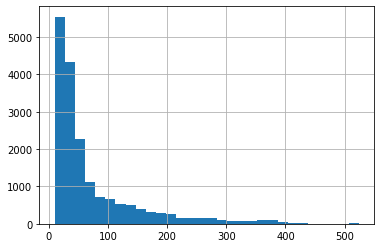

In [5]:
pd.Series(np.array(list((map(lambda r: len(r.words), reference_documents))))).hist(bins=30)
len(reference_documents)

### Spectral data at integer precision - trimmed above certain intensity

In [6]:
%%capture
#first we train peak embeddings at integer m/z precision

# Load data from MSP file and apply filters

spectrums_trimmed = [spectrum_processing(s,min_rel_int=.02) for s in load_from_msp("data/MoNA-export-GC-MS_Spectra.msp")];

# Omit spectrums that didn't qualify for analysis
spectrums_trimmed = [s for s in spectrums_trimmed if s is not None]


# Create spectrum documents

reference_documents_trimmed = [SpectrumDocument(s, n_decimals=0) for s in spectrums_trimmed];


18171

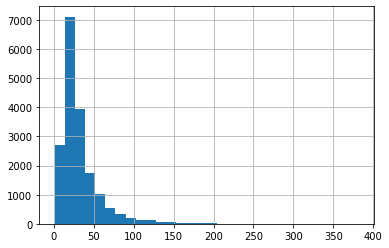

In [7]:
pd.Series(np.array(list((map(lambda r: len(r.words), reference_documents_trimmed))))).hist(bins=30)
len(reference_documents_trimmed)

In [8]:
# note that with this kind of trimming we can reuse the train test split between original and trimmed docs
# but we are not guaranteed to have always a minimal number of peaks present

### Spectral data at 2dec precision
Skipped due to reasons stated in the intro text

In [9]:
#reference_documents_2dec = [SpectrumDocument(s, n_decimals=2) for s in spectrums];


## Gas2Vec model
Load or train the w2v Gensim model using spec2vec library.

Either load pretrained file or uncomment the training and train your own.

In [10]:
# train integer w2v 
from spec2vec.model_building import train_new_word2vec_model

model_file = "gas2vec/references_integer.model"
#model_int = train_new_word2vec_model(reference_documents, iterations=list(range(0,100,5)), filename=model_file,
#                                workers=32, progress_logger=True)


In [11]:
from gensim.models import Word2Vec 
w2v = Word2Vec.load(wv_path)    
#w2v = Word2Vec.load("references_2dec.model")   

In [12]:
# get w2v vocab
vocab = {e:i for i, e in enumerate(w2v.wv.index2entity)}
None

In [13]:
np.array(reference_documents[0].words)

array(['peak@51', 'peak@55', 'peak@57', 'peak@58', 'peak@59', 'peak@60',
       'peak@61', 'peak@62', 'peak@63', 'peak@66', 'peak@68', 'peak@70',
       'peak@72', 'peak@73', 'peak@74', 'peak@75', 'peak@76', 'peak@78',
       'peak@80', 'peak@81', 'peak@82', 'peak@83', 'peak@86', 'peak@87',
       'peak@92', 'peak@93', 'peak@94', 'peak@98', 'peak@99', 'peak@100',
       'peak@104', 'peak@107', 'peak@108', 'peak@110', 'peak@112',
       'peak@113', 'peak@115', 'peak@116', 'peak@120', 'peak@122',
       'peak@123', 'peak@124', 'peak@125', 'peak@126', 'peak@134',
       'peak@135', 'peak@137', 'peak@147', 'peak@149', 'peak@150',
       'peak@151', 'peak@159', 'peak@162', 'peak@163', 'peak@173',
       'peak@174', 'peak@175', 'peak@177', 'peak@187', 'peak@188',
       'peak@189', 'peak@190', 'peak@191', 'peak@198', 'peak@199',
       'peak@200', 'peak@201', 'peak@202', 'peak@203', 'peak@207',
       'peak@214', 'peak@217', 'peak@218', 'peak@247', 'peak@248'],
      dtype='<U8')

In [14]:
w2v.wv.index2entity
None

## Spectral embeddings
We will also get spec2vec spectral embeddings (weighted sum) of our data. Although we dont currently use it. 

In [15]:
from spec2vec import Spec2Vec
# Define similarity_function
spec2vec_similarity = Spec2Vec(model=w2v, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

spectral_embeddings = np.empty(shape=(len(reference_documents), 300))

for i, doc in enumerate(reference_documents):
    spectral_embeddings[i] = spec2vec_similarity._calculate_embedding(doc)
    
spectral_embeddings[:10]

array([[-11.2521921 ,  66.92814401,  63.03613326, ...,  -6.68343374,
        154.10666904,  45.98240031],
       [ 83.45619161,  10.05940665,   3.9605179 , ..., -18.7849128 ,
         30.4395823 ,  59.103414  ],
       [ 23.21466286, -18.74373438,  11.96270582, ...,  19.06691796,
        -29.28918407,  -1.60732649],
       ...,
       [ 17.14168013, -17.08560857,  17.84208137, ...,  23.50678032,
        -24.0843337 ,  -3.41370882],
       [ 45.54508623, -22.87093729,  22.65664517, ...,  22.82420153,
        -20.16175343,  32.45071412],
       [ 28.17583382, -35.81548421,  33.0399032 , ...,  35.87810207,
        -26.77738867,  -4.64142304]])

In [16]:
spectral_embeddings.shape

(18171, 300)

# Spectral Model

Even though high-quality embeddings can help with model training, it may be possible that we can train a good model even without such embeddings. 

Therefore we directly implement and inspect the spectral models. 

## Spectras to Dataset
Now we transform the Spec2Vec data format into torch Dataset. We have 2 major approaches for training - "language generation", and "given top k, predict y". Current version supports the full language genreration with teacher forcing. Also with minor changes bacward compatibility with "give, predict" task can be done. With this adjustmenst the following are also supported: "given k most intense, predict \[k+1th | random peak | all peaks\]" with the default k=5


In [17]:
class TopKDS(Dataset):
    def __init__(self, ref_docs, vocab, k=5, onehot=True, add_intensity=False, mode="one"):
        self.ref_docs = ref_docs
        self.k = k         
        self.vocab=vocab
        
        # drop too little peaky spectra
        self.ref_docs = [dr for dr in self.ref_docs if len(dr.words) > k]
        self.d_position = 0
        
        self.onehot=onehot
        self.add_intensity = add_intensity
        self.mode = mode
        
        # get indeces mapping 
        if self.mode == "all":
            self.counts = list(map(lambda ref_doc: len(ref_doc.peaks)-self.k, self.ref_docs))
            nested_mapping = [list(zip([i]*n, range(n))) for i,n in enumerate(self.counts)]
            self.mapping = [item for sublist in nested_mapping for item in sublist]
            
    def __len__(self) -> int:
        if self.mode == "all":
            return sum(self.counts)
        return len(self.ref_docs)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        
        if self.mode == "all":
            idx, y_idx = self.mapping[idx]
        
        top_k, top_after_k = self.get_top_k_ind(self.ref_docs[idx].peaks.intensities)
        
        if self.add_intensity:
            top_k_intens = self.ref_docs[idx].peaks.intensities[top_k]
            X = self.encode_spec_intens(np.array(self.ref_docs[idx].words)[top_k], top_k_intens)
        else:
            X = self.encode_spec(np.array(self.ref_docs[idx].words)[top_k])
        
        to_predict = top_after_k
        if self.mode == "all":
            to_predict = y_idx
        if self.mode == "random":
            to_predict = np.random.randint(0,len(self.ref_docs[idx].peaks))    
            
        y = self.encode(np.array(self.ref_docs[idx].words)[to_predict])
        return X, y
    
    def get_top_k_ind(self, arr):
        arg_sorted = np.argsort(arr)[::-1]
        
        top_k = arg_sorted[:self.k]
        top_after_k = arg_sorted[self.k]
        
        return top_k, top_after_k
    
    
    def size(self):
        return len(self.vocab)
    
    def encode(self, peak):
        return torch.tensor(self.vocab[peak], dtype=int)
    
    def encode_spec(self, spec, intens=None):
        if self.onehot:
            res = torch.empty((len(spec), len(self.vocab)))                
        else:
            res = torch.empty((len(spec)), dtype=int)
        
        for i, peak in enumerate(spec):
            if self.onehot:
                res[i] = nn.functional.one_hot(self.encode(peak), len(self.vocab))
            else:
                res[i] = self.encode(peak)
        return res
    
    def encode_spec_intens(self, spec, intens):
        if self.onehot:
            res = torch.empty((len(spec), len(self.vocab)+1))
        else:
            res = torch.empty((len(spec), 2), dtype=float)
        
        for i, peak in enumerate(spec):
            if self.onehot:
                res[i] = torch.cat((nn.functional.one_hot(self.encode(peak), len(self.vocab)), torch.tensor(intens[i]).reshape(-1)))
            else:
                res[i] = torch.tensor((self.encode(peak), intens[i]))
        return res


Second dataset class alow us to do a "language generation" task. 

In [18]:
class GenDS(Dataset):
    def __init__(self, ref_docs, vocab, onehot=True, add_intensity=False):
        self.ref_docs = sorted(ref_docs, key=lambda doc: len(doc.words), reverse=True)
        self.vocab=vocab
        
        self.onehot=onehot
        self.add_intensity = add_intensity
            
    def __len__(self) -> int:
        return len(self.ref_docs)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        
        ordered_ind = np.argsort(self.ref_docs[idx].peaks.intensities)[::-1]
        X_ind = ordered_ind[:-1]
        y_ind = ordered_ind[1:]
        if self.add_intensity:
            intens = self.ref_docs[idx].peaks.intensities[X_ind]
            X = self.encode_spec_intens(np.array(self.ref_docs[idx].words)[X_ind], intens)
        else:
            X = self.encode_spec(np.array(self.ref_docs[idx].words)[X_ind])
        
        y = torch.tensor([self.encode(peak) for peak in np.array(self.ref_docs[idx].words)[y_ind]])
        return X, y
    
    def size(self):
        return len(self.vocab)
 
    def encode(self, peak):
        return torch.tensor(self.vocab[peak], dtype=int)
    
    def encode_spec(self, spec):
        if self.onehot:
            res = torch.empty((len(spec), len(self.vocab)))                
        else:
            res = torch.empty((len(spec)), dtype=int)
        
        for i, peak in enumerate(spec):
            if self.onehot:
                res[i] = nn.functional.one_hot(self.encode(peak), len(self.vocab))
            else:
                res[i] = self.encode(peak)
        return res
    
    def encode_spec_intens(self, spec, intens):
        if self.onehot:
            res = torch.empty((len(spec), len(self.vocab)+1))
        else:
            res = torch.empty((len(spec), 2), dtype=float)
        
        for i, peak in enumerate(spec):
            if self.onehot:
                res[i] = torch.cat((nn.functional.one_hot(self.encode(peak), len(self.vocab)), torch.tensor(intens[i]).reshape(-1)))
            else:
                res[i] = torch.tensor((self.encode(peak), intens[i]))
        return res

def gen_collate(batch):
    padded = nn.utils.rnn.pad_sequence([item[0] for item in batch], batch_first=True, padding_value=0)
    target = nn.utils.rnn.pad_sequence([item[1] for item in batch], batch_first=True, padding_value=-100)
    
    target = torch.LongTensor(target)
    return [padded, target]

## Models definiton
Time to get some models.

In [19]:
       
class PureLSTM(nn.Module):
    def __init__(self, size, hidden_size, add_intens=False):
        super(PureLSTM, self).__init__()
        self.in_features = size
        self.add_intens = add_intens
        if add_intens:
            self.in_features += 1    
        self.out_features = size
        
        
        self.lstm = nn.LSTM(input_size=self.in_features, hidden_size=hidden_size, 
                            num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_size, self.out_features)
        
        self.log_softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, seq, return_sequence=True, init_state=None):
        output, (h_n, c_n) = self.lstm(seq, init_state)
        #last_y = self.linear(h_n[-1])
        if not return_sequence:
            last_y = self.linear(h_n[-1])
            return self.log_softmax(last_y), (h_n, c_n)
    
        
        res = [] 
        for h in output:
            logits = self.linear(h)
            res.append(self.log_softmax(logits))
        
        return torch.stack(res), (h_n, c_n)
    
           
class EmbeddLSTM(nn.Module):
    def __init__(self, size, hidden_size, wv, freeze_wv=True, add_intens=False):
        super(EmbeddLSTM, self).__init__()
        self.add_intens = add_intens
        self.embedding = nn.Embedding.from_pretrained(wv, freeze=freeze_wv)
        
        self.in_features = self.embedding.embedding_dim
        if add_intens:
            self.in_features += 1
        self.out_features = size
        
        
        self.lstm = nn.LSTM(input_size=self.in_features, hidden_size=hidden_size, 
                            num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_size, size)
        
        self.log_softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, seq, return_sequence=True, init_state=None):
        if self.add_intens:
            indices, intens = seq[:,:,0], seq[:,:,1]
            embedded_seq = self.embedding(indices.int())
            embedded_seq =torch.cat((embedded_seq, intens.reshape(*intens.shape,1)), dim=-1).float()
        else:
            embedded_seq = self.embedding(seq)
            
        output, (h_n, c_n) = self.lstm(embedded_seq, init_state)
        
        if not return_sequence:
            last_y = self.linear(h_n[-1])
            return self.log_softmax(last_y), (h_n, c_n)
        
        res = [] 
        for h in output:
            logits = self.linear(h)
            res.append(self.log_softmax(logits))
        return torch.stack(res), (h_n, c_n)
    
class MostFrequentDummy(nn.Module):
    def __init__(self, ds, per_k=False):
        super(MostFrequentDummy, self).__init__()
        self.add_intens = False
        
        
        self.cntr = Counter(self.get_occurence(ds))
        
        self.logprobs = torch.ones(len(ds.vocab))
        
        for d in self.cntr:
            self.logprobs[ds.vocab[f"peak@{d}"]] += self.cntr[d]
        self.logprobs = torch.log(self.logprobs/self.logprobs.sum())
        
        #self.most_common = self.cntr.most_common(1)[0][0]
#             locations, counts = np.array(sorted(zip(occurences.keys(), occurences.values() ), key=lambda x: x[0])).T

        self.per_k = per_k
    
        self.cntr_per_k = [*map(lambda all_: Counter(all_), self.get_occurence_per_k(ds))]
        self.logprobs_per_k = torch.ones(len(self.cntr_per_k),len(ds.vocab))
        for k, cntr in enumerate(self.cntr_per_k):
            for d in cntr:
                self.logprobs_per_k[k][ds.vocab[f"peak@{d}"]] += cntr[d]
        
        self.logprobs_per_k = torch.log(self.logprobs_per_k/self.logprobs_per_k.sum(dim=1, keepdims=True))

        
    def get_occurence(self,ds):
        all_ = []
        for i in range(len(ds)):
            all_ += [*map(lambda p: int(p.split("@")[1]), ds.ref_docs[i].words)]
        return all_
    
    def get_occurence_per_k(self, ds):
        max_len = max(map(lambda x: len(x.words), ds.ref_docs))
        k_all_ = [[1] for _ in range(max_len*2)]
        for i in range(len(ds)):
            for j, p in enumerate(ds.ref_docs[i].words):
                if j>= max_len:
                    print(j)
                k_all_[j].append(int(p.split("@")[1]))
        return k_all_
    
    
    def forward(self, seq, return_sequence=True, init_state=0):
        with torch.no_grad():
            if self.per_k:
                if return_sequence:
                    return torch.stack([self.logprobs_per_k[init_state: len(seq[0])] for i in range(len(seq))]), init_state + len(seq[0])
                return torch.stack([self.logprobs_per_k[init_state + len(seq[0])-1]]*len(seq)), init_state + len(seq[0])

            if return_sequence:
                return torch.stack([self.logprobs]* len(seq) * len(seq[0])).reshape(len(seq), len(seq[0]), -1), init_state + len(seq[0])
            return torch.stack([self.logprobs]* len(seq)), init_state + len(seq[0])


## Training utils
Let's define the learner class that's take care about the training with early stopping. 

We also split the data into train-val-test sets. 


In [20]:
class Learner():
    def __init__(self,train_loader, val_loader, model, optimizer, loss_fn, device, style, model_name="model"):
        self.train_loader= train_loader
        self.val_loader = val_loader
        self.model = model 
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.model_name=model_name
        self.train_losses = []
        self.val_losses = []
        self.style = style
        
        
    def evaluate(self, loader):
        eval_loss = 0
        self.model.eval()
        self.model.to(self.device)
        for b, (X, y) in enumerate(loader):
            with torch.no_grad():
                X, y = X.to(self.device), y.to(self.device)
                if self.style == "given_k":
                    log_pred,_ = self.model(X, return_sequence=False)
                    loss = self.loss_fn(log_pred, y)
                else:
                    log_pred, _ = self.model(X)
                    loss = self.loss_fn(log_pred.reshape(-1, log_pred.shape[2]), y.ravel())
                
                eval_loss += loss.item()
            
        eval_loss /= len(loader)
        
        return eval_loss
    
    def train(self,n_epochs, early_stopping=True, patience=3):
        self.model.to(self.device)

        if early_stopping:
            min_val_loss = np.inf
            no_improve = 0
        
        
        e_bar = tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True, desc="Epoch: ")
        for e in e_bar:
            # train
            train_loss = 0
            self.model.train()
            for b, (X, y) in enumerate(self.train_loader):
                X, y = X.to(self.device), y.to(self.device)
                # zero the parameter gradients
                self.optimizer.zero_grad()
                
                if self.style == "given_k":
                    log_pred,_ = self.model(X, return_sequence=False)
                    loss = self.loss_fn(log_pred, y)
                else:
                    log_pred, _ = self.model(X)
                    loss = self.loss_fn(log_pred.reshape(-1, log_pred.shape[2]), y.ravel())
              
                loss.backward()
                self.optimizer.step()

            # evaluate (train, validation)
            train_loss = self.evaluate(self.train_loader)
            val_loss = self.evaluate(self.val_loader)

            # early stopping
            if early_stopping:
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    torch.save(self.model, "models/" + self.model_name)
                    no_improve = 0
                else:
                    no_improve += 1
            if no_improve > patience:
                print("Early stopped")
                self.model = torch.load("models/" + self.model_name)
                break
            
            #print(f"After {e+1} epochs: ")
            e_bar.set_postfix({'Train loss': f"{train_loss:.3}",'Val loss': f"{val_loss:.3}" })
            #print(f"Train loss: {train_loss:.3}")
            #print(f"Val loss: {val_loss:.3}\n")
                
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
        return self.train_losses, self.val_losses
    

In [21]:
    
split = int(len(reference_documents)*.8)
split2 = int(len(reference_documents)*.9)

ind = np.zeros(len(reference_documents))
ind[split:split2] = 1
ind[split2:] = 2

np.random.seed(42)
np.random.shuffle(ind)


train_ind = np.where(ind==0)[0]
val_ind = np.where(ind==1)[0]
test_ind = np.where(ind==2)[0]

def get_sub(docs, indcs):
    return [docs[i] for i in indcs]

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [22]:
ind[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 1., 0.,
       2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])

In [23]:
len(train_ind), len(val_ind), len(test_ind)

(14536, 1817, 1818)

## Training mode - "Given top k, predict [k+1th/random/all remaining]"

In [24]:


# train_DS = TopKDS(reference_documents[:split], vocab=vocab, k=5, mode="one")
# val_DS = TopKDS(reference_documents[split:split2], vocab=vocab, k=5, mode="one")
# test_DS = TopKDS(reference_documents[split2:], vocab=vocab, k=5, mode="one")

# train_loader = DataLoader(train_DS, batch_size=128, shuffle=True, num_workers=8)
# val_loader = DataLoader(val_DS, batch_size=128, shuffle=True, num_workers=8)

# style="given_k"


## Training mode - "Language generation"

In [25]:
train_DS = GenDS(get_sub(reference_documents, train_ind), vocab=vocab)
val_DS = GenDS(get_sub(reference_documents, val_ind), vocab=vocab)
test_DS = GenDS(get_sub(reference_documents, test_ind), vocab=vocab)

train_loader = DataLoader(train_DS, batch_size=256, shuffle=False, num_workers=8, collate_fn=gen_collate)
val_loader = DataLoader(val_DS, batch_size=256, shuffle=False, num_workers=8, collate_fn=gen_collate)


style="generation"

In [26]:
def train(model, train_DS, val_DS, train_loader, val_loader, model_name, lr=1e-3, patience=10, max_epoch=500, \
          init_b=lambda n: "bias" in n, init_w=lambda n: "weight" in n and "lstm" in n, device="cpu"):
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.NLLLoss()

    #init weights
    for name, param in model.named_parameters():
        if init_b(name):
            nn.init.constant_(param, 0.0)
        elif init_w(name):
            nn.init.xavier_normal_(param)
            
    train_DS.onehot = isinstance(model, PureLSTM)
    train_DS.add_intensity=model.add_intens
    val_DS.onehot = isinstance(model, PureLSTM)
    val_DS.add_intensity=model.add_intens
    
    learner = Learner(train_loader, val_loader, model, optim, loss_fn, device,style, model_name)
    learner.train(max_epoch, patience)
    plot_training(learner)
    return learner

In [27]:
def plot_training(learner):
    plt.figure(figsize=(8, 8))
    plt.plot(learner.train_losses)
    plt.plot(learner.val_losses)
    plt.legend(["training loss", "validation loss"])
    plt.title(f"{learner.model_name} - loss over epochs")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    #plt.ylim(1,2)
    plt.show()

## Models instantiation and training
We specify and train several variants to better understand the domain.

In [28]:
# dummmy
dummy = MostFrequentDummy(train_DS)
dummy_per_k = MostFrequentDummy(train_DS, per_k=True)

In [29]:
train_DS.vocab[f"peak@{dummy.cntr.most_common()[0][0]}"]

0

In [30]:
for i in range(10):
    print(train_DS.vocab[f"peak@{dummy_per_k.cntr_per_k[i].most_common()[0][0]}"])

179
27
19
62
10
53
1
20
9
50


Epoch:  11%|█         | 56/500 [23:31<3:06:32, 25.21s/it, Train loss=4.48, Val loss=4.51] 

Early stopped


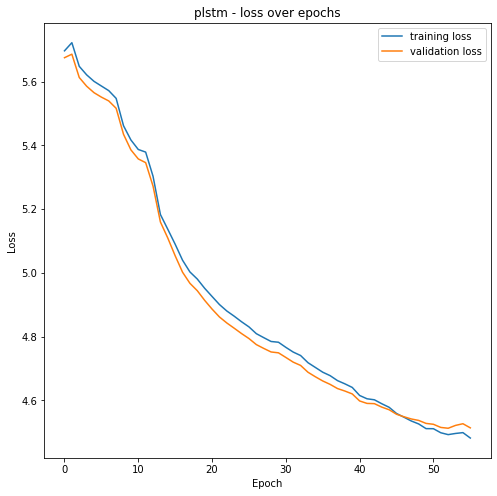

In [31]:
# pure LSTM on onehotted peaks
plstm = PureLSTM(size=train_DS.size(), hidden_size=200).to(device)
plstm_learner = train(plstm, train_DS, val_DS, train_loader, val_loader, "plstm", device=device)


Epoch:  13%|█▎        | 64/500 [32:12<3:39:25, 30.20s/it, Train loss=4.3, Val loss=4.45] 

Early stopped


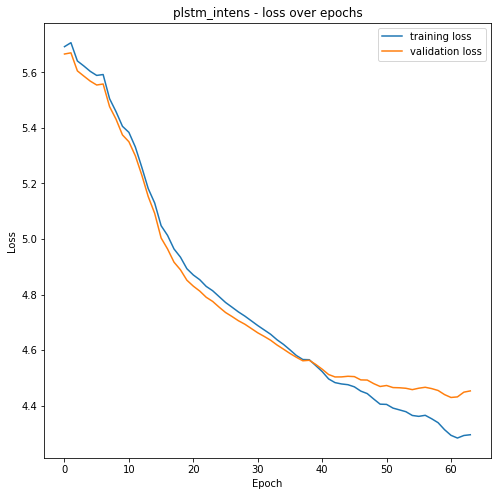

In [32]:
# pure LSTM on onehotted peaks with the intensity feature
plstm_intens = PureLSTM(size=train_DS.size(), hidden_size=200, add_intens=True).to(device)
plstm_intens_learner = train(plstm_intens, train_DS, val_DS, train_loader, val_loader, "plstm_intens", device=device)

Epoch:   8%|▊         | 38/500 [11:04<2:14:44, 17.50s/it, Train loss=4.18, Val loss=4.37]

Early stopped


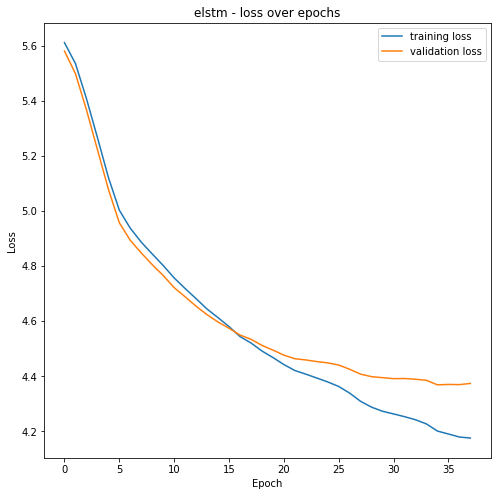

In [33]:
# LSTM on the Spec2Vec embeddings (that are freezed - not trained)
elstm = EmbeddLSTM(size=train_DS.size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors)).to(device)
elstm_learner = train(elstm, train_DS, val_DS, train_loader, val_loader, "elstm", device=device)

Epoch:   9%|▊         | 43/500 [13:47<2:26:36, 19.25s/it, Train loss=4.11, Val loss=4.37]

Early stopped


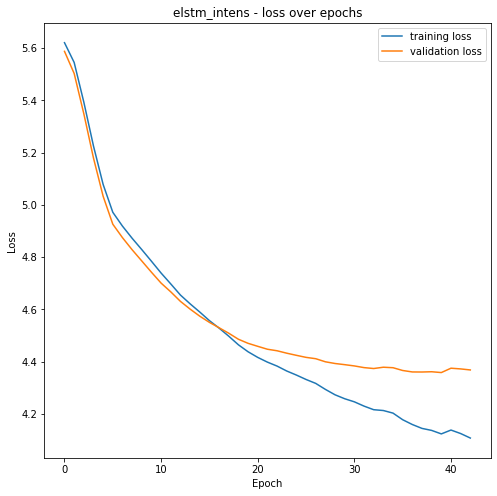

In [34]:
# LSTM on the Spec2Vec embeddings (that are freezed - not trained) with added intensity
elstm_intens = EmbeddLSTM(size=train_DS.size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors), add_intens=True).to(device)
elstm_intens_learner = train(elstm_intens, train_DS, val_DS, train_loader, val_loader, "elstm_intens", device=device)

Epoch:   8%|▊         | 41/500 [11:43<2:07:53, 16.72s/it, Train loss=4.14, Val loss=4.39]

Early stopped


Epoch:   8%|▊         | 41/500 [11:59<2:14:20, 17.56s/it, Train loss=4.14, Val loss=4.39]


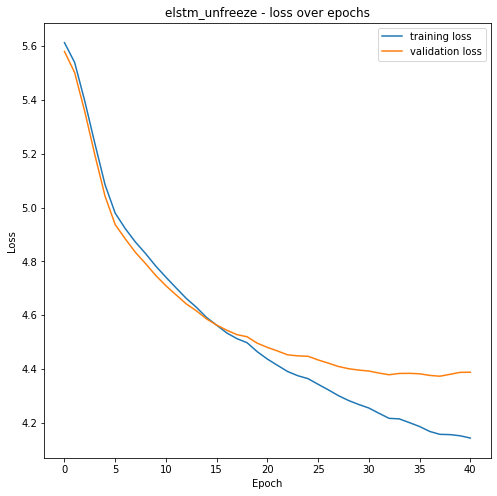

In [35]:
# LSTM on the Spec2Vec embeddings (that are not freezed - trained)
elstm_unfreeze = EmbeddLSTM(size=train_DS.size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors), freeze_wv=False).to(device)
elstm_unfreeze_learner = train(elstm_unfreeze, train_DS, val_DS, train_loader, val_loader, "elstm_unfreeze", device=device)

Epoch:   7%|▋         | 35/500 [11:18<2:30:12, 19.38s/it, Train loss=4.21, Val loss=4.39]

Early stopped


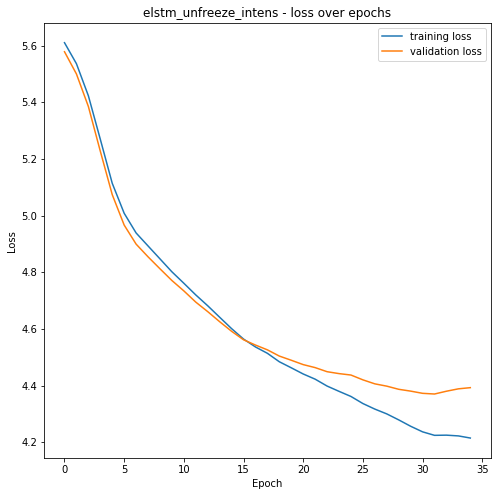

In [36]:
# LSTM on the Spec2Vec embeddings (that are not freezed - trained) with added intensity
elstm_unfreeze_intens = EmbeddLSTM(size=train_DS.size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors), freeze_wv=False, add_intens=True).to(device)
elstm_unfreeze_intens_learner = train(elstm_unfreeze_intens, train_DS, val_DS, train_loader, val_loader, "elstm_unfreeze_intens", device=device)

Epoch:  14%|█▍        | 72/500 [21:17<2:06:32, 17.74s/it, Train loss=4.18, Val loss=4.38]

Early stopped


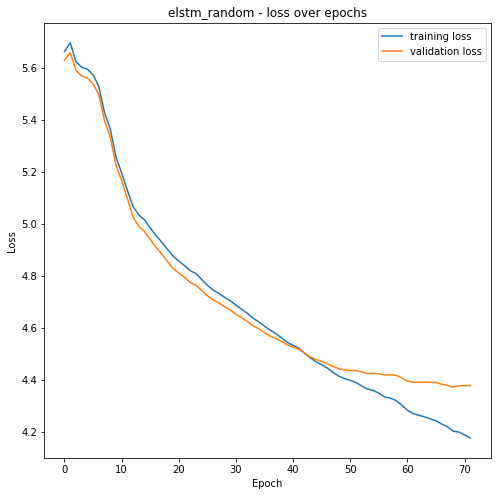

In [37]:
# LSTM on the random embeddings (that are not freezed - trained)
elstm_random = EmbeddLSTM(size=train_DS.size(), hidden_size=200,wv=torch.zeros_like(torch.tensor(w2v.wv.vectors)), freeze_wv=False).to(device)
elstm_random_learner = train(elstm_random, train_DS, val_DS, train_loader, val_loader, "elstm_random", device=device, init_w=lambda n: "weight" in n)

Epoch:  12%|█▏        | 61/500 [22:33<2:27:35, 20.17s/it, Train loss=4.27, Val loss=4.39]

Early stopped


Epoch:  12%|█▏        | 61/500 [22:53<2:44:43, 22.51s/it, Train loss=4.27, Val loss=4.39]


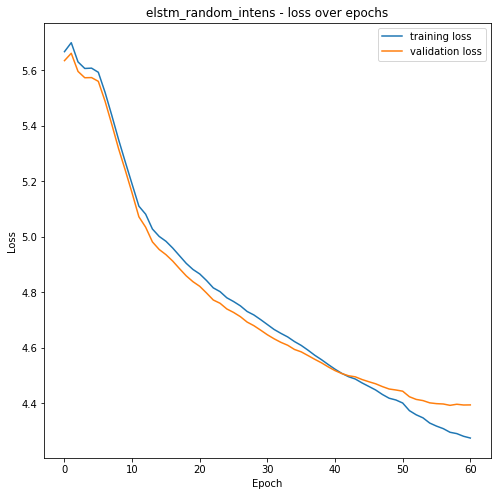

In [38]:
# LSTM on the random embeddings (that are not freezed - trained) with added intensity
elstm_random_intens = EmbeddLSTM(size=train_DS.size(), hidden_size=200,wv=torch.zeros_like(torch.tensor(w2v.wv.vectors)), freeze_wv=False, add_intens=True).to(device)
elstm_random_intens_learner = train(elstm_random_intens, train_DS, val_DS, train_loader, val_loader, "elstm_random_intens", device=device, init_w=lambda n: "weight" in n)

Epoch:   6%|▌         | 29/500 [10:03<2:34:30, 19.68s/it, Train loss=4.27, Val loss=4.4] 

Early stopped


Epoch:   6%|▌         | 29/500 [10:23<2:48:44, 21.50s/it, Train loss=4.27, Val loss=4.4]


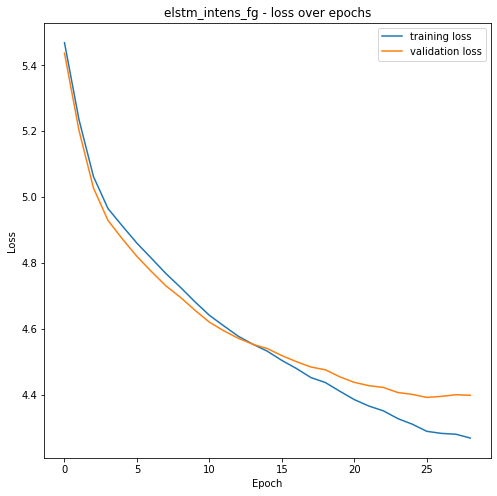

In [39]:
# LSTM on the Spec2Vec embeddings (that are freezed - not trained) with added intensity and large initial forget gate bias
elstm_intens_fg = EmbeddLSTM(size=train_DS.size(), hidden_size=200,wv=torch.tensor(w2v.wv.vectors), freeze_wv=True, add_intens=True).to(device)

# init large forget gate bias
for name, param in elstm_intens_fg.named_parameters():
    if "bias" in name and "lstm" in name:
        bias = param
        n = bias.size(0)
        start, end = n//4, n//2
        bias.data[start:end].fill_(1.)

elstm_intens_fg_learner = train(elstm_intens_fg, train_DS, val_DS, train_loader, val_loader, "elstm_intens_fg", device=device, init_b=lambda x: False)

### Training results
Here we present the development of the loss until the training was early stopped. Notice the y axis numbers!

In [40]:
learners = [plstm_learner, plstm_intens_learner, elstm_learner, elstm_intens_learner, 
            elstm_random_learner, elstm_random_intens_learner, elstm_unfreeze_learner,
           elstm_unfreeze_intens_learner, elstm_intens_fg_learner]

In [41]:
for le in learners:
    min_val = min(le.val_losses)
    print(f"Model {le.model_name} has val loss {min_val:.3}")

Model plstm has val loss 4.51
Model plstm_intens has val loss 4.43
Model elstm has val loss 4.37
Model elstm_intens has val loss 4.36
Model elstm_random has val loss 4.37
Model elstm_random_intens has val loss 4.39
Model elstm_unfreeze has val loss 4.37
Model elstm_unfreeze_intens has val loss 4.37
Model elstm_intens_fg has val loss 4.39


## Observation:

TODO

Models with embedding layer tends to achieve better val losses. Most notably LSMT on top on freezed Spec2vec embeddings was the best. Still, the difference between embeddings by spec2vec and random ones is almost neglible. 

--> Although embedding layer helps, spec2vec does not improve the model drastically. It makes sense since it has not seen any other data then what we are using for the nonlinear (LSTM/Transformers,...) model. Naturally, this nonlinear model is able to learn similar things as the linear one (Word2vec) does. Even though the optimization criterion is slightly different.

### Forget gate biases:

In [42]:
for init, l in zip(["normal", "large"],[elstm_intens_learner, elstm_intens_fg_learner]):
    print(f"Model initilized with {init}: ")
    for name, param in l.model.named_parameters():
        if "bias" in name and "lstm" in name:
            bias = param
            n = bias.size(0)
            start, end = n//4, n//2
            print(f"Bias sum: {bias.data[start:end].sum()}")


Model initilized with normal: 
Bias sum: 22.011754989624023
Bias sum: 22.011754989624023
Bias sum: 21.410011291503906
Bias sum: 21.410011291503906
Model initilized with large: 
Bias sum: 212.241455078125
Bias sum: 212.241455078125
Bias sum: 207.4625244140625
Bias sum: 207.4625244140625


## Inspection
Following is a painful and ugly attempt (plotting is ...) to display both original spectra and predicted distribution for next peak by the Spectral Models.

We focus mostly on the LSTM with freezed embeddings. Let's see if it learnt anything useful.

In [43]:
def peakindex_to_loc(i, n_dec):
    return peakname_to_loc(w2v.wv.index2entity[i], n_dec)

def peakname_to_loc(peakname, n_dec):
    return int(float(peakname.split("@")[-1])*(10**n_dec)) 

def pred_to_bars(pred, bars_len, n_dec):
    bars = np.zeros(bars_len)
    for i in range(len(pred)):
        loc = peakindex_to_loc(i, n_dec)
        bars[loc] = pred[i]
    return bars

def plot_spectrum(ds, model, n_detail=10, index=0, plot_full=True, log_y=False):
    """
    Parameters
    ----------
        ds - torch dataset from which to take the samples
        model - trained nn.Module model
        n_detail - number of most intensive peaks with detailed m/z location 
        index - index of sample in the dataset ds
    """
    
    ds.onehot = isinstance(best_model, PureLSTM)
    ds.add_intensity = best_model.add_intens
    
    
    # TODO add decimals plot support with meaningful plots
    
    # basic variables
    ref_doc = ds.ref_docs[index]    
    n_dec = ref_doc.n_decimals
    base = np.arange(1001*(10**n_dec))
    bars_len = len(base)
    p_inten = ref_doc.weights
    
    ######################
    # reference spectrum #
    ######################
    
    # create an y axis array of bars
    bars = np.zeros(len(base))
    for p, peak in enumerate(ref_doc.words):
        loc = peakname_to_loc(peak, n_dec)
        bars[loc] = max(bars[loc],p_inten[p])
      
    # get top_k_ind
    top_k_ind, top_after = ds.get_top_k_ind(ref_doc.peaks.intensities)
    
    # distinguish top_k peaks by color
    hue = np.repeat("regular peak", bars_len)
    for ind in top_k_ind:
        hue[peakname_to_loc(ref_doc.words[ind], n_dec)] = f"one of top {len(top_k_ind)}"
    
    if plot_full:
        # plot it
        f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(40, 10), sharex=True)
        ax1 = sns.barplot(x=base, y=bars, hue=hue, ax=ax1)

    
    # add labels on top of n_details most intensive peaks    
    max_l_ref = np.sort(bars)[-n_detail]
    big_ref = np.nonzero( bars >= max_l_ref)[0]
    
    if plot_full:
        plt.sca(ax1)
        for loc in big_ref:
            plt.text(loc, bars[loc]+np.max(bars)/20, loc, ha='center', rotation=90, va='bottom')

    
    #########################
    # predicted distributon #
    #########################
    
    # get top k as model input
    X, y = ds[index]
    model = model.to("cpu")
    
    # predict top k+1
    with torch.no_grad():
        log_prob, _ = model(X.reshape(1, *X.shape), return_sequence=False)
        prob = np.exp(log_prob)[0]
    
    # convert prediction from spec2vec indexing to location on mz indexing
    bars_pred = pred_to_bars(prob, bars_len, n_dec)
    
    
    # add labels on top of n_details most probable peaks
    max_l = np.sort(bars_pred)[-n_detail]
    big = np.nonzero( bars_pred >= max_l)[0]    
    
    if plot_full:
        plt.sca(ax2)
        for loc in big:
            plt.text(loc, bars_pred[loc]+np.max(bars_pred)/20, loc, ha='center', rotation=90, va='bottom')

        # plot it
        ax2 = sns.barplot(x=base, y=bars_pred, ax=ax2, color="red")    
        
        if log_y:
            ax1.set(yscale="log")
            ax2.set(yscale="log")
            
            ax2.set_ylim(10e-5)
            ax1.sharey(ax2)
        
        ax1.title.set_text(f"Full reference spectrum of {ref_doc.metadata['name']}")
        ax2.title.set_text(f"Predicted distribution for {len(top_k_ind)+1}. peak")
        ax1.xaxis.set_tick_params(labelbottom=True)
        ax1.set(ylabel='intensity')
        ax2.set(xlabel='m/z', ylabel='probability')
        plt.sca(ax1)
        plt.xticks(ticks=np.arange(0,1001,10),fontsize=8, rotation=45)
        plt.sca(ax2)
        plt.xticks(ticks=np.arange(0,1001,10), fontsize=8, rotation=45)
        plt.show()

    ##################################
    # focused wiew on the dense area #
    ##################################
    
    # get focus area with np.quantile and nasty hack
    meta = []
    for peak, intensity in zip(ref_doc.words, p_inten):
        meta += [peakname_to_loc(peak, n_dec)]*int(intensity*1000)
    focus = max(0, np.quantile(meta, 0.05) -50), np.quantile(meta, 0.95) + 50
    
    
    #plot focused 
    f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(20, 10), sharex=True)
    ax1 = sns.barplot(x=base, y=bars, ax=ax1, hue=hue)
    ax2 = sns.barplot(x=base, y=bars_pred, ax=ax2, color="red")
    
    # add labels on top of peaks
    plt.sca(ax1)
    for loc in big_ref:
        plt.text(loc, bars[loc]+np.max(bars)/20, loc, ha='center', rotation=90, va='bottom')
    plt.sca(ax2)
    for loc in big:
        plt.text(loc, bars_pred[loc]+np.max(bars_pred)/20, loc, ha='center', rotation=90, va='bottom')
    
    #plot focused
    if log_y:
        ax1.set(yscale="log")
        ax2.set(yscale="log")
        #ax2.sharey(ax1)
        
        ax2.set_ylim(10e-5)
        ax1.sharey(ax2)
    
    ax1.title.set_text(f"Focused reference spectrum of {ref_doc.metadata['name']}")
    ax2.title.set_text(f"Predicted distribution for {len(top_k_ind)+1}. peak")
    ax1.set_xlim(*focus)
    ax2.set_xlim(*focus)
    ax1.xaxis.set_tick_params(labelbottom=True)
    ax2.xaxis.set_tick_params(labelbottom=True)
    ax1.set(ylabel='intensity')
    ax2.set(xlabel='m/z', ylabel='probability')
    plt.sca(ax1)
    plt.xticks(ticks=np.arange((focus[0]//10)*10, (focus[1]//10)*10, 5 ),fontsize=8, rotation=45)
    plt.sca(ax2)
    plt.xticks(ticks=np.arange((focus[0]//10)*10, (focus[1]//10)*10, 5 ), fontsize=8, rotation=45)
    plt.show()

In [44]:
# let's load the sucessful model 
best_model = torch.load("models/elstm_intens",  map_location=torch.device(device))    

In [45]:
# and observe some predictions on unseen data
test_DS_k = TopKDS(get_sub(reference_documents, test_ind), vocab=vocab, k=5, mode="one")

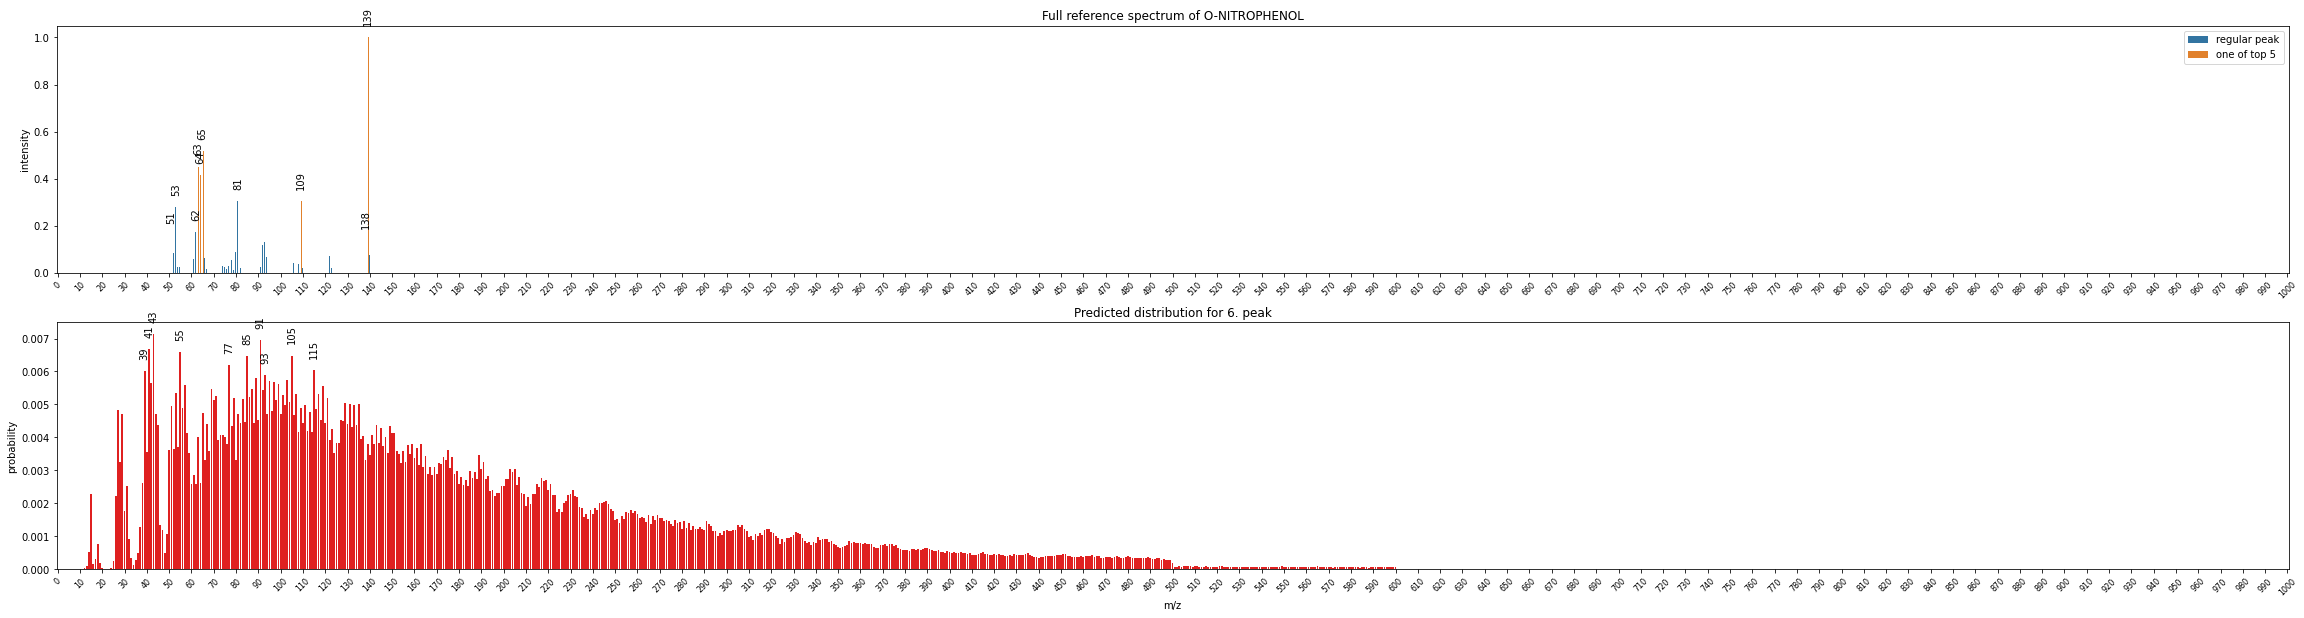

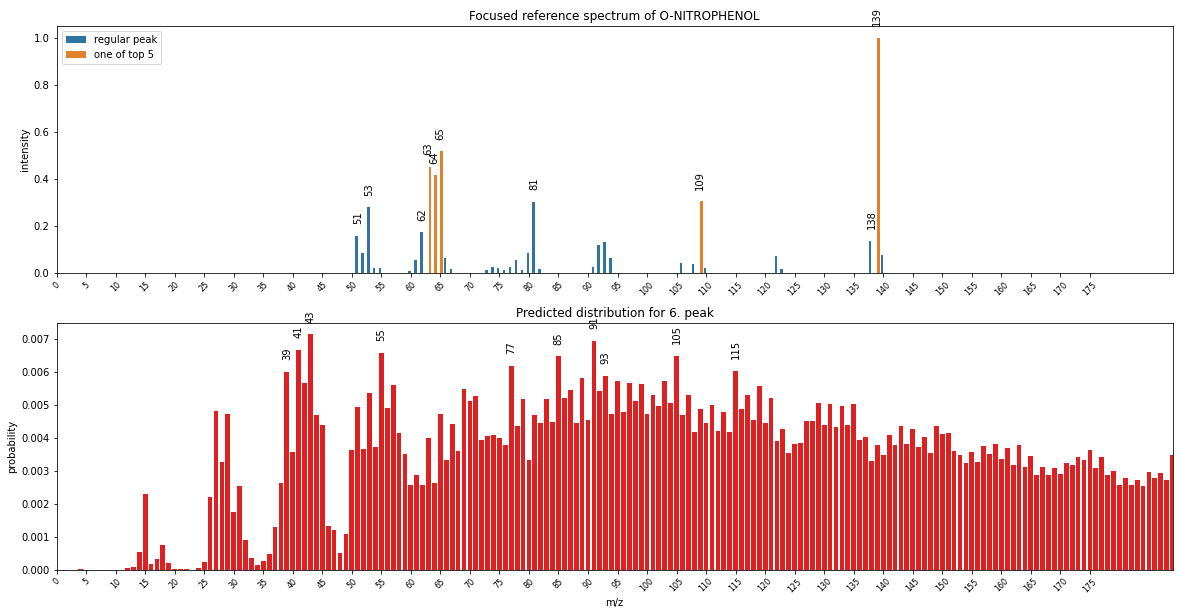

In [46]:
# import matplotlib
# matplotlib.rc_file_defaults()
# first lets see the dummy 
plot_spectrum(test_DS_k, dummy, 10, 0)

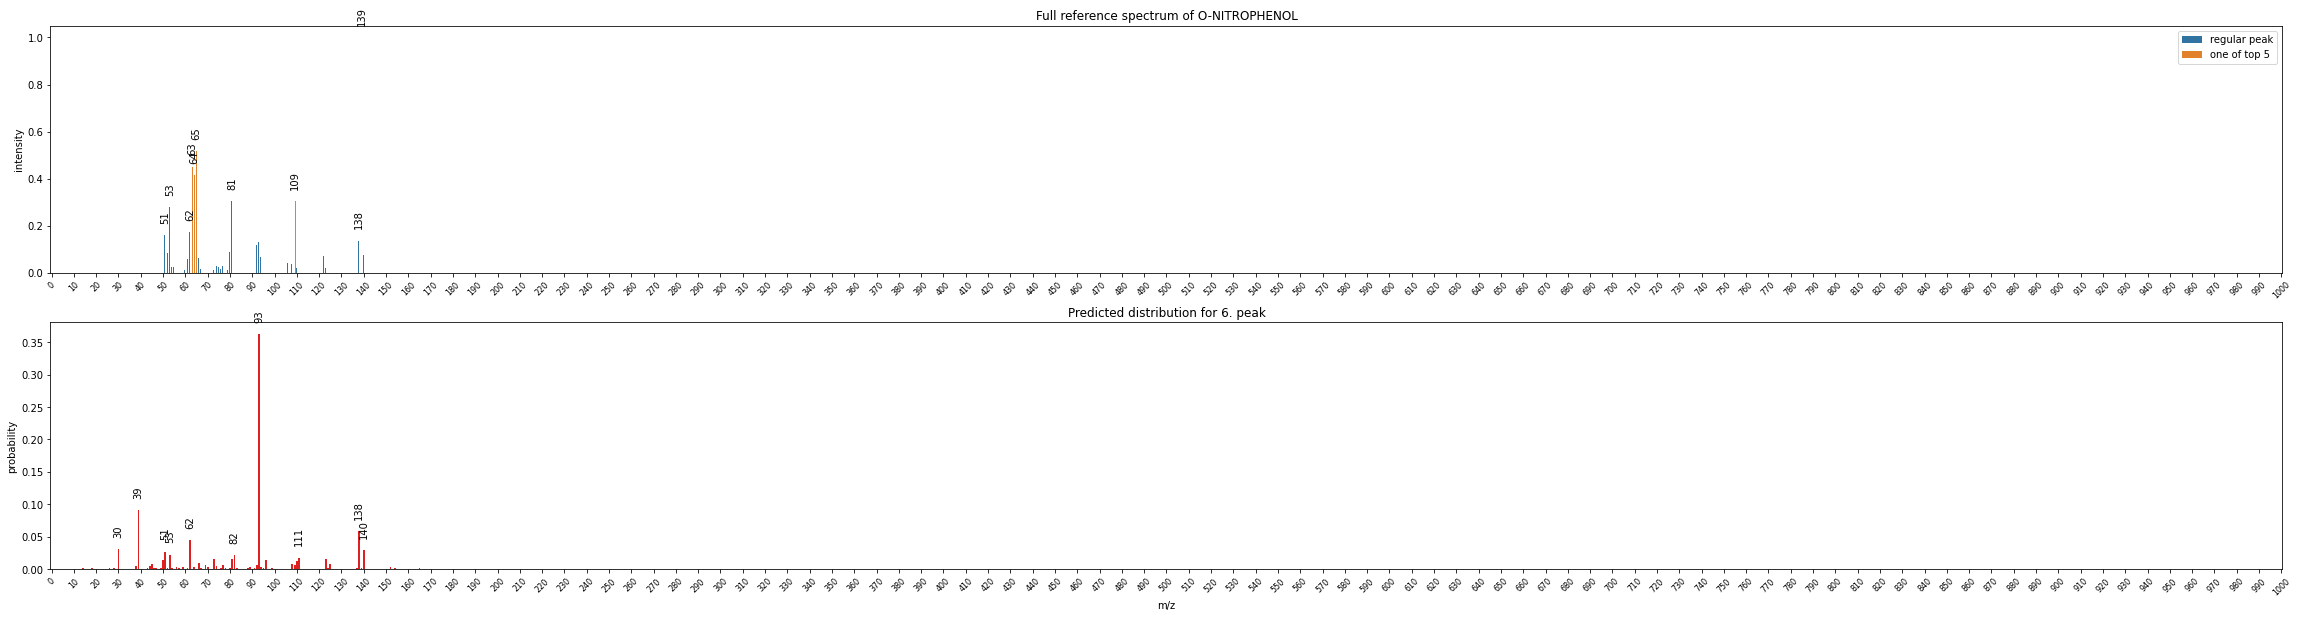

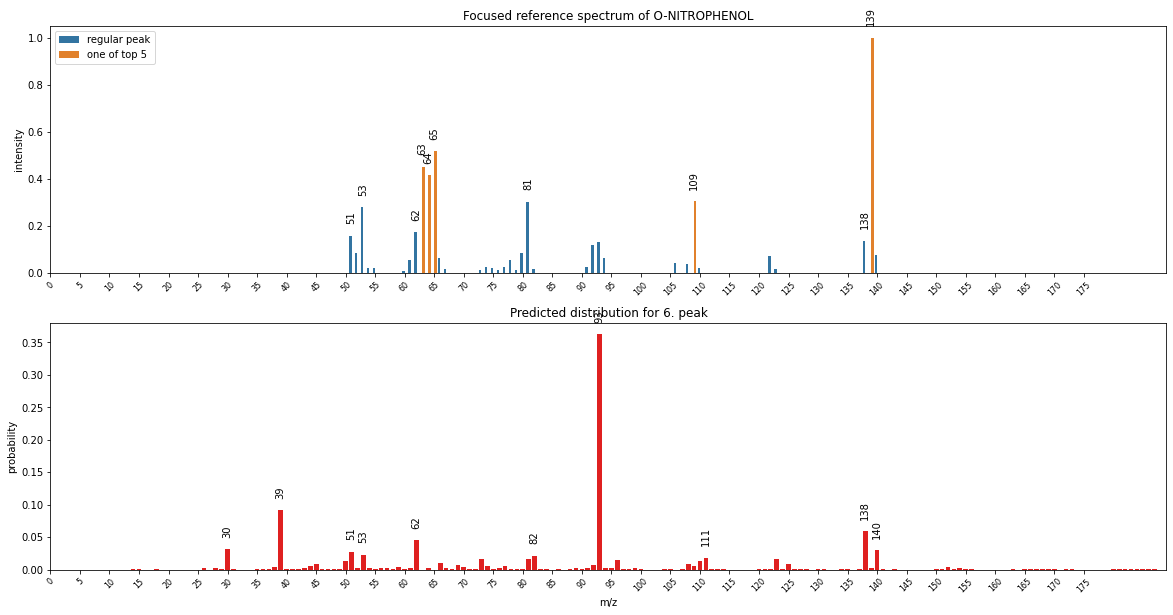

In [47]:
# then see our model 
plot_spectrum(test_DS_k, best_model, 10, 0)

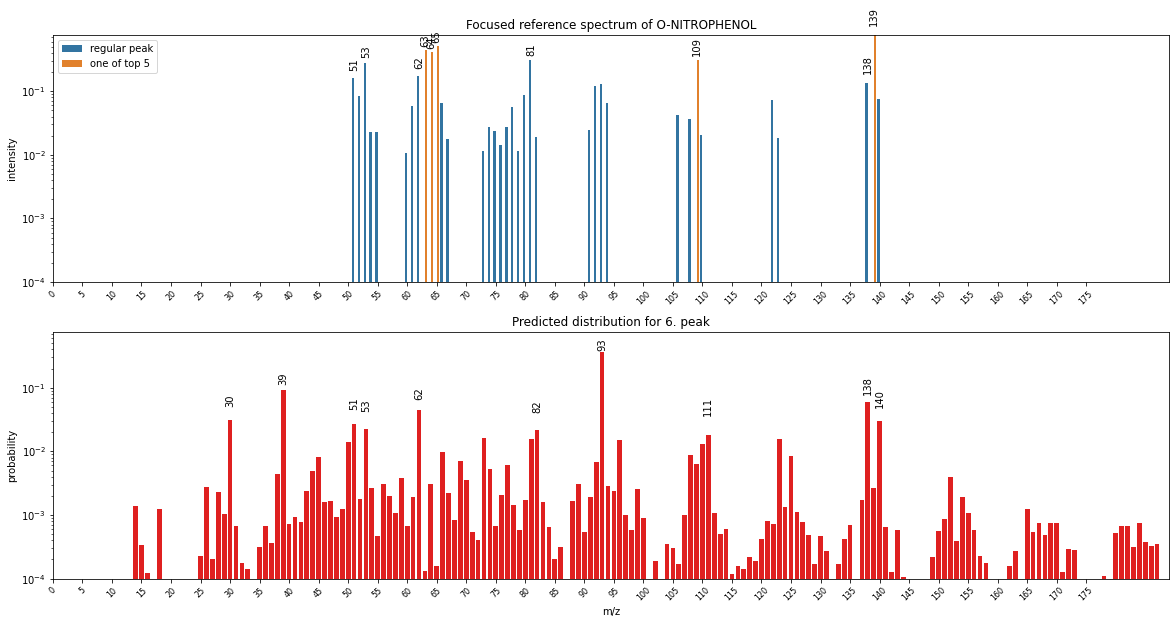

In [48]:
# plot it in log scale
plot_spectrum(test_DS_k, best_model, 10, 0, plot_full=False, log_y=True)

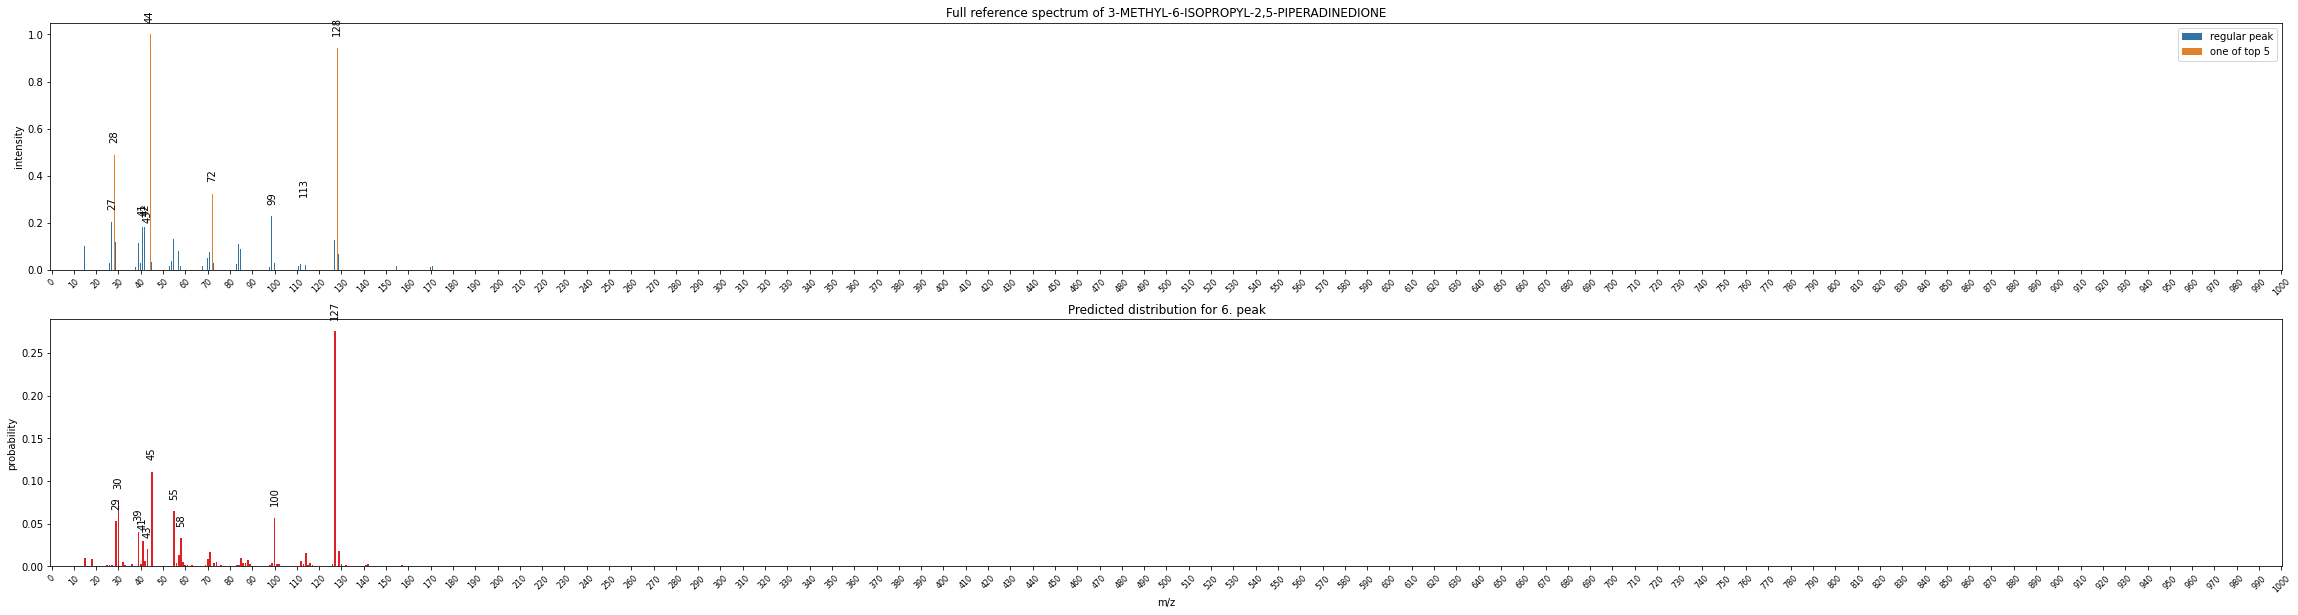

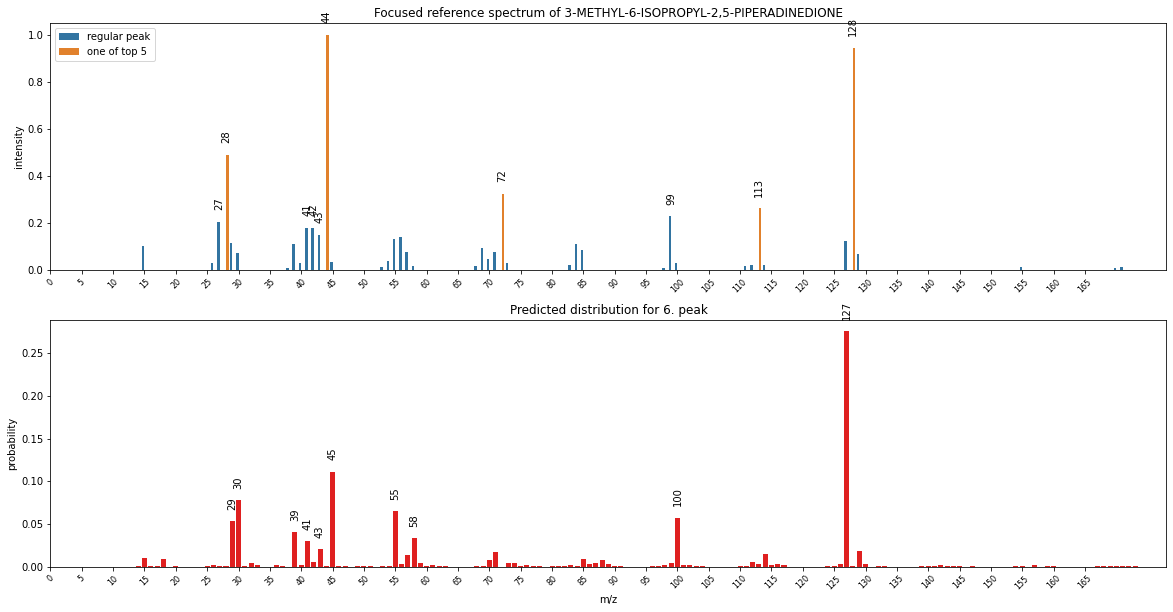

In [49]:
plot_spectrum(test_DS_k, best_model, 10, 5)

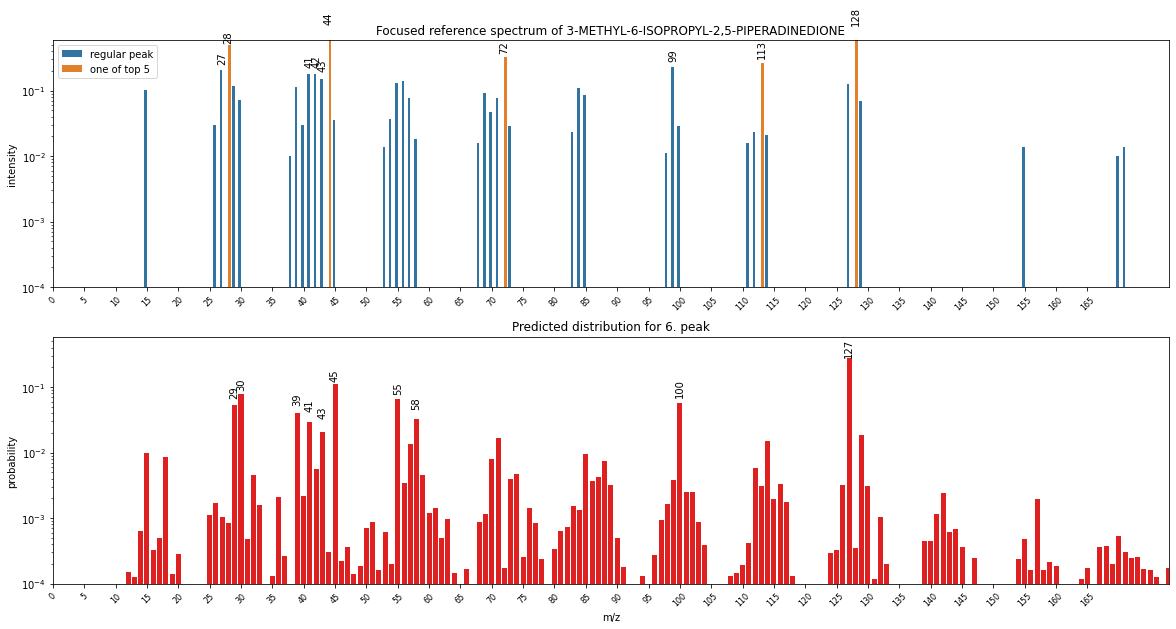

In [50]:
#profile 

#%pip install line_profiler
#%load_ext line_profiler

#%lprun -f plot_spectrum plot_spectrum(test_DS_k, best_model, 10, 5, plot_full=False, log_y=True)
plot_spectrum(test_DS_k, best_model, 10, 5, plot_full=False, log_y=True)

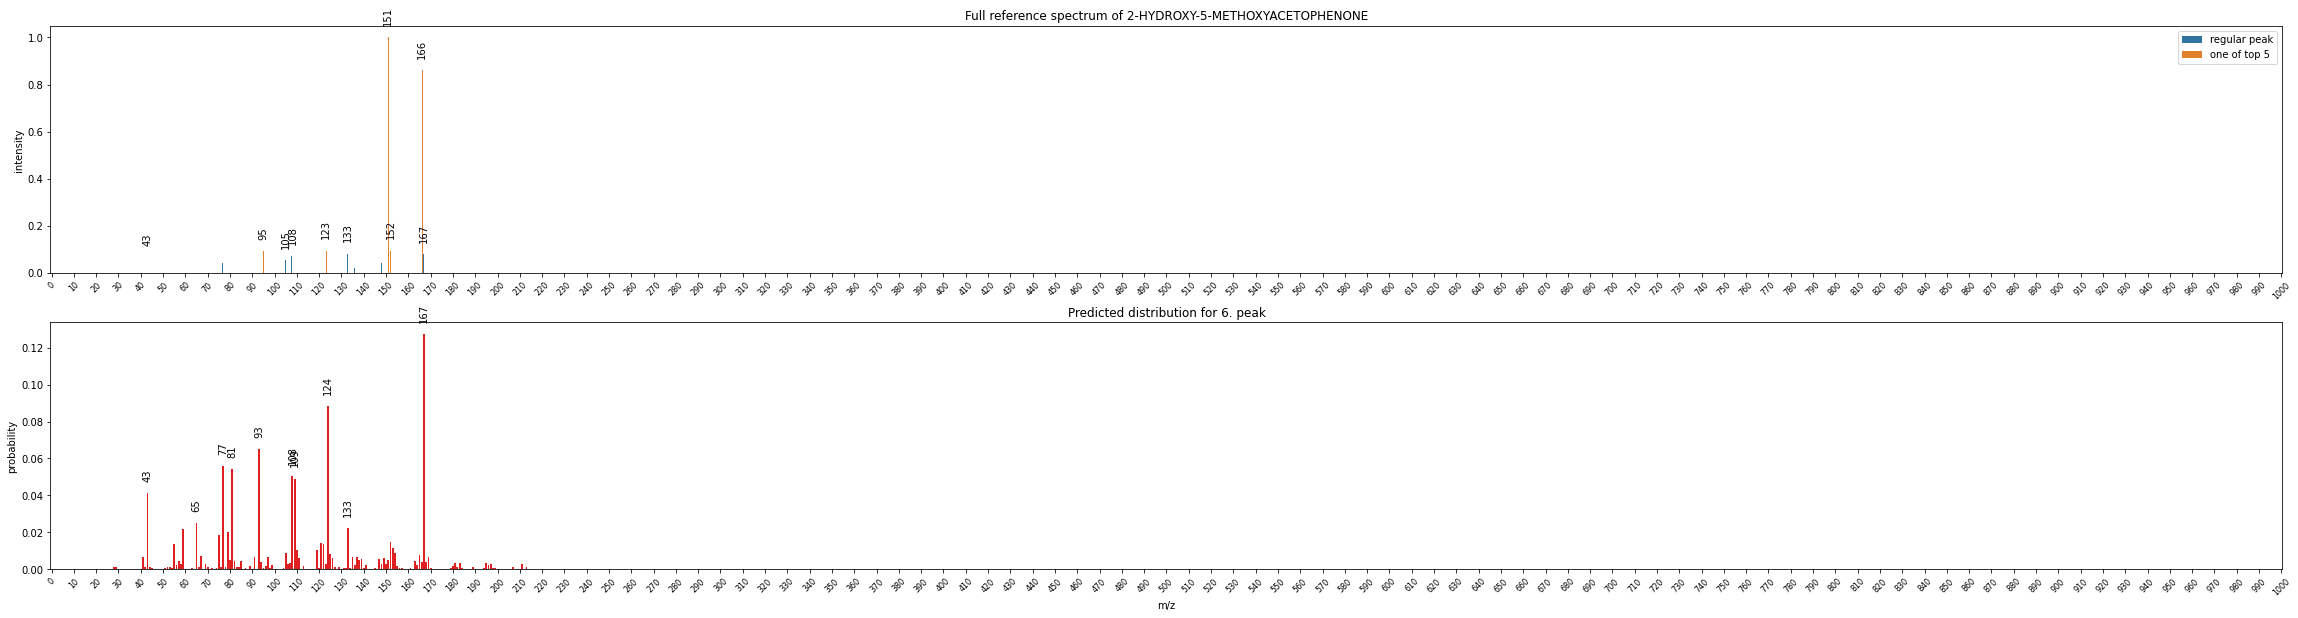

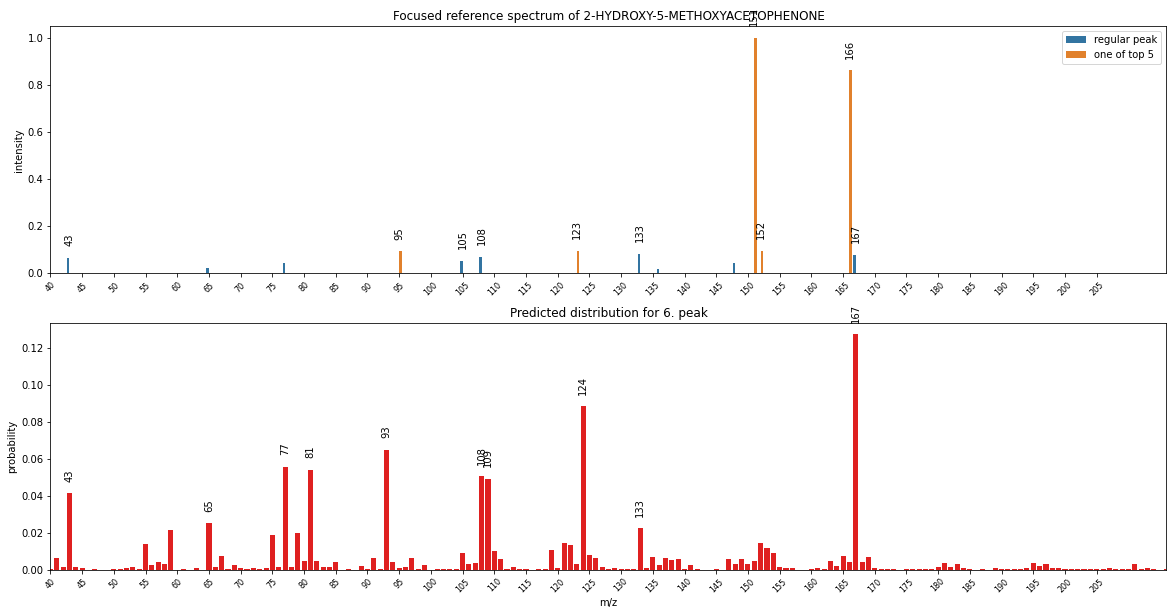

In [51]:
plot_spectrum(test_DS_k, best_model, 10, 50)

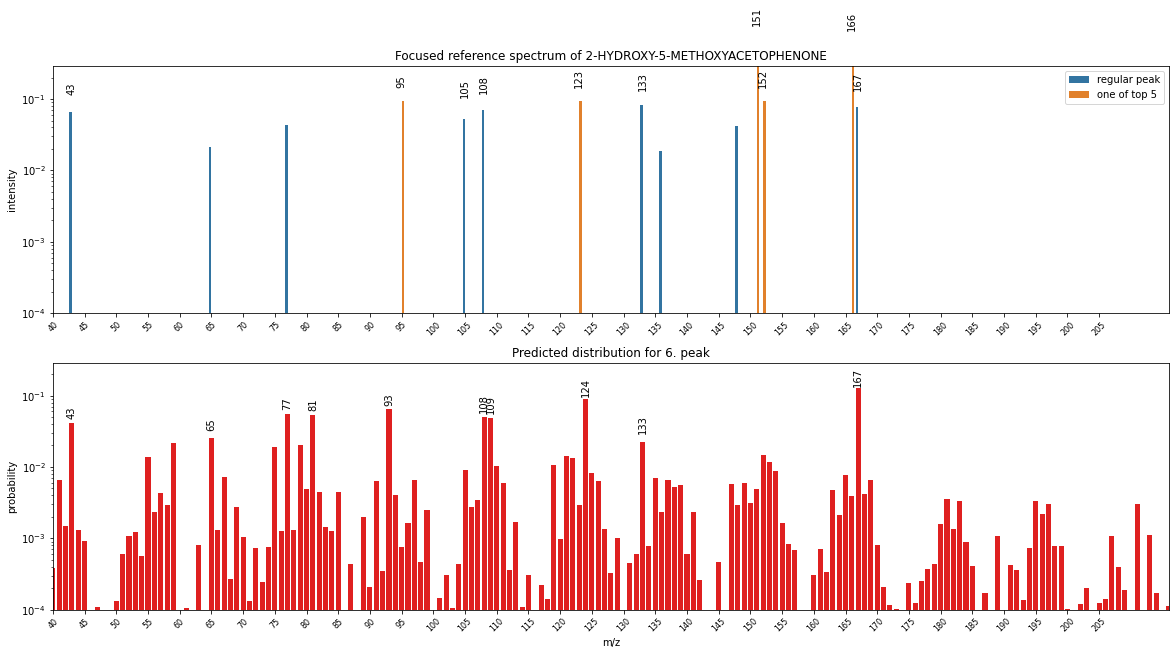

In [52]:
plot_spectrum(test_DS_k, best_model, 10, 50, plot_full=False, log_y=True)

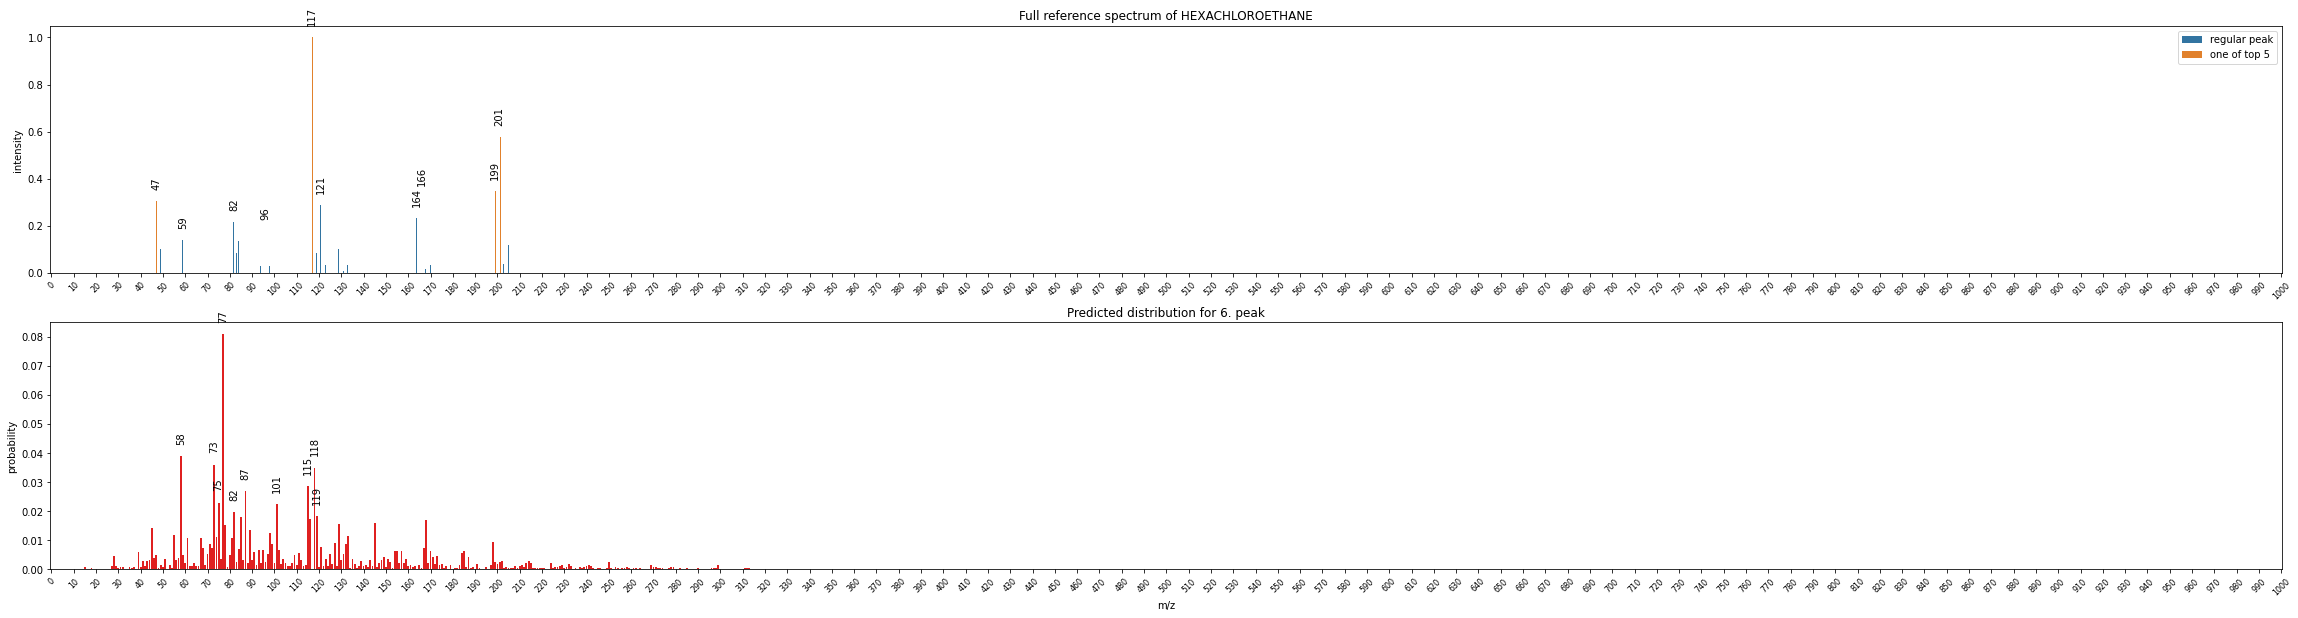

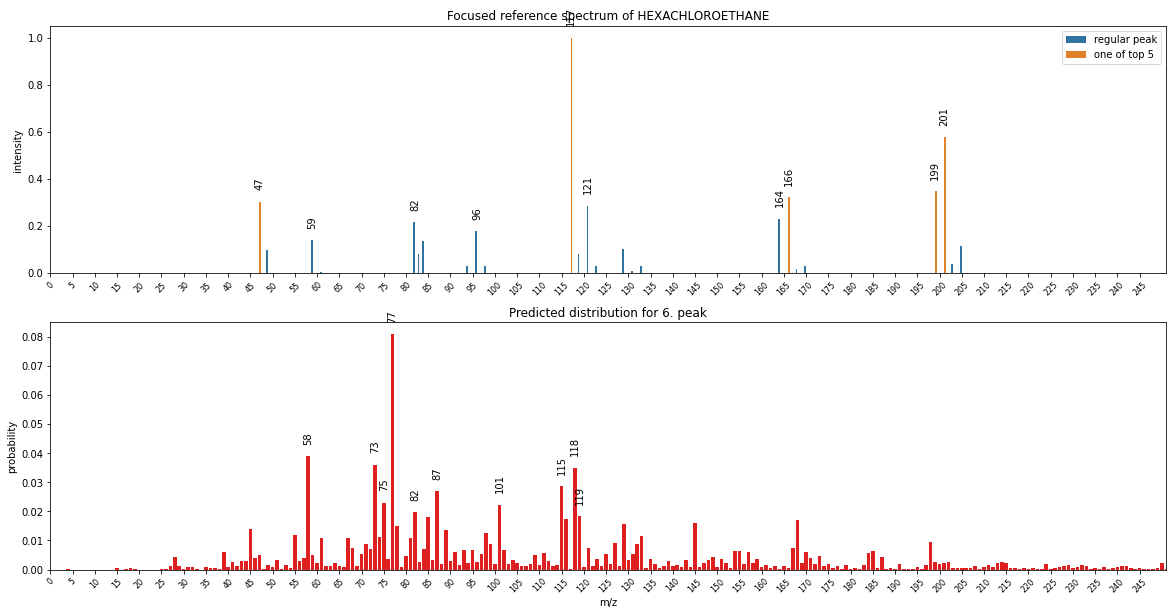

In [53]:
plot_spectrum(test_DS_k, best_model, 10, 100)

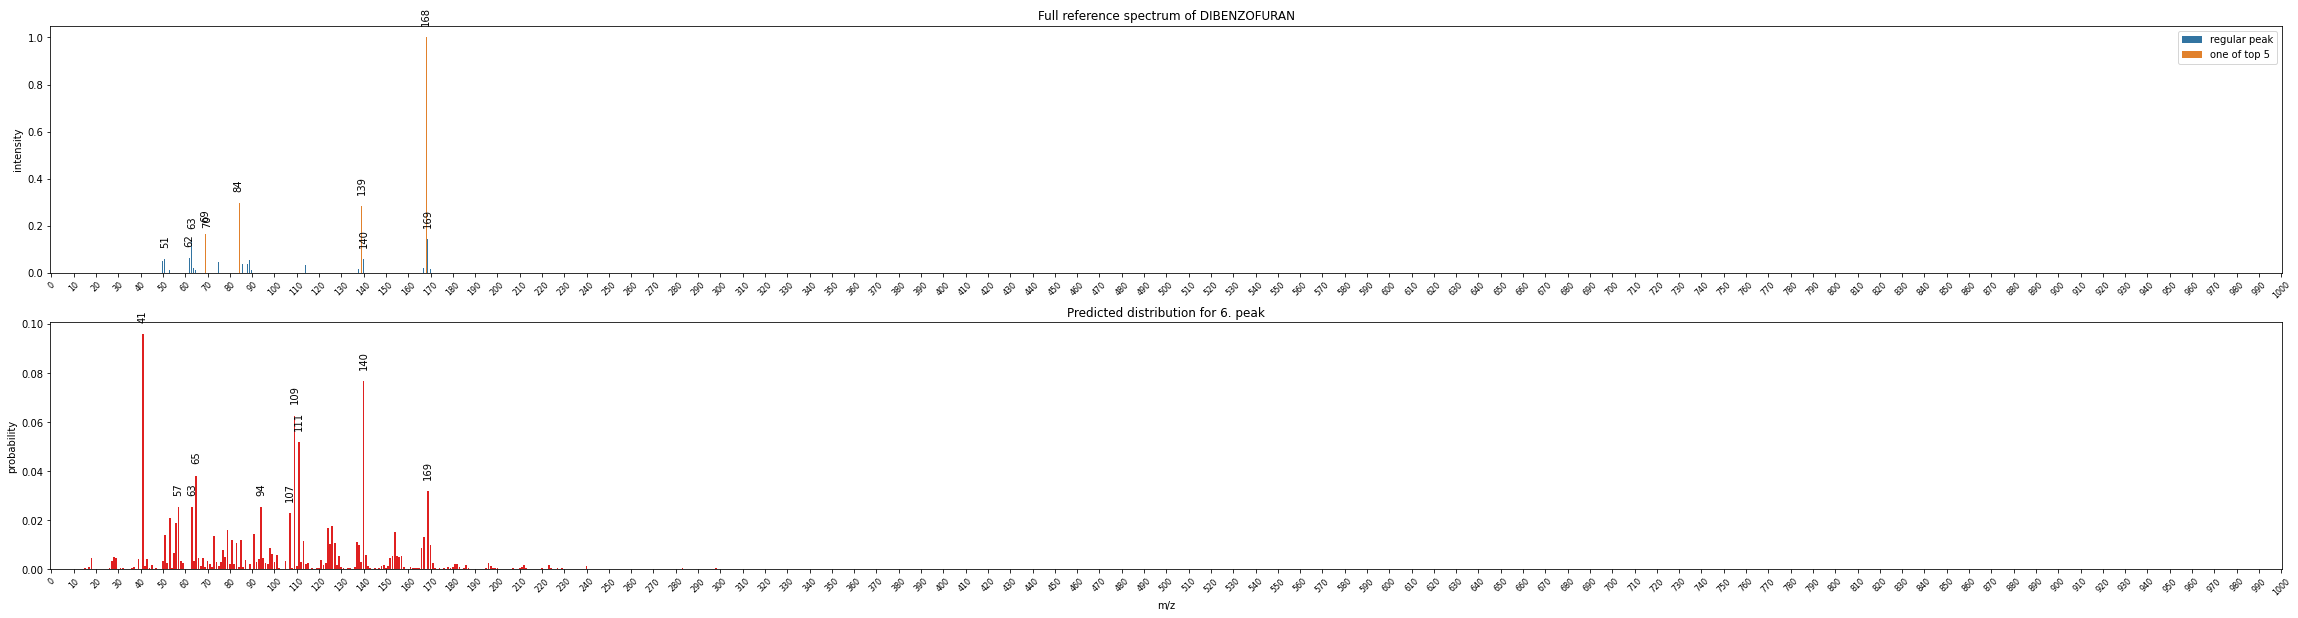

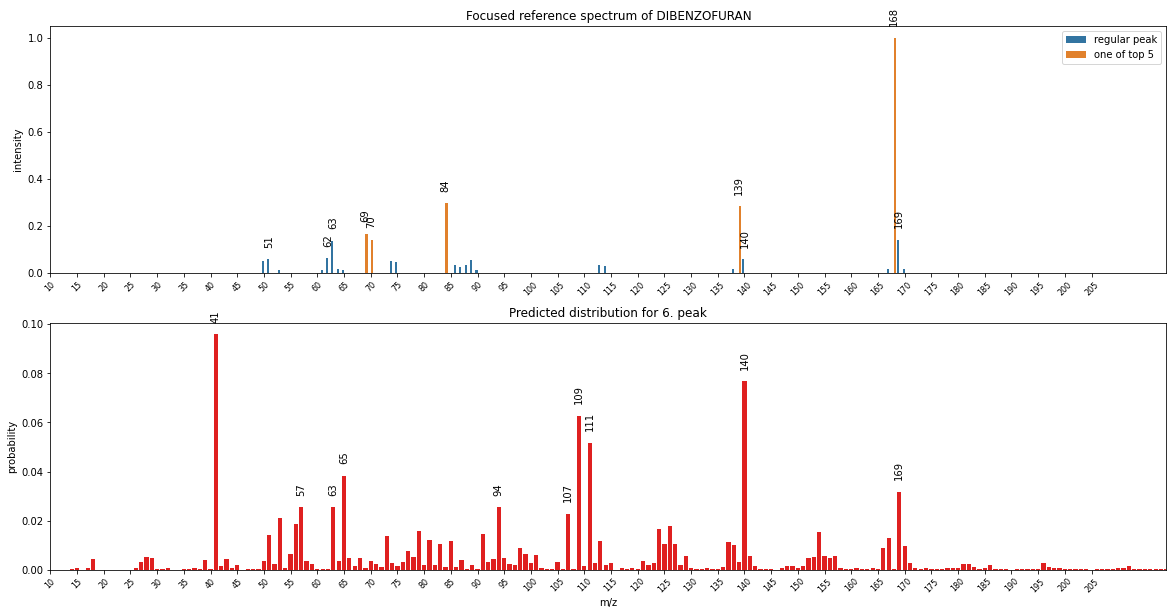

In [54]:
plot_spectrum(test_DS_k, best_model, 10, 150)

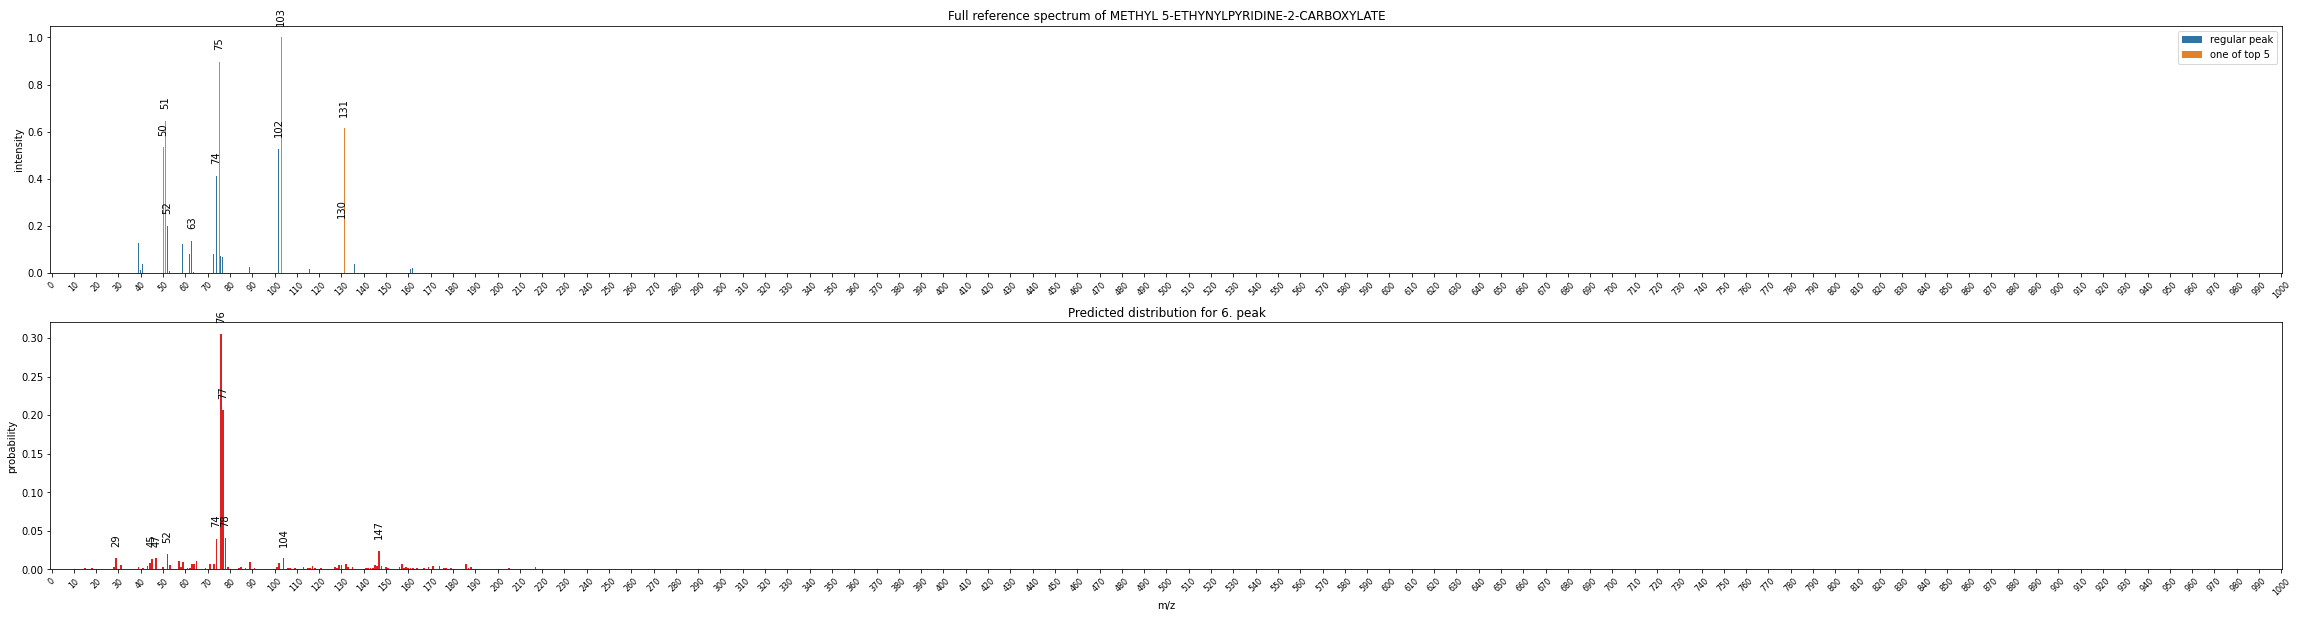

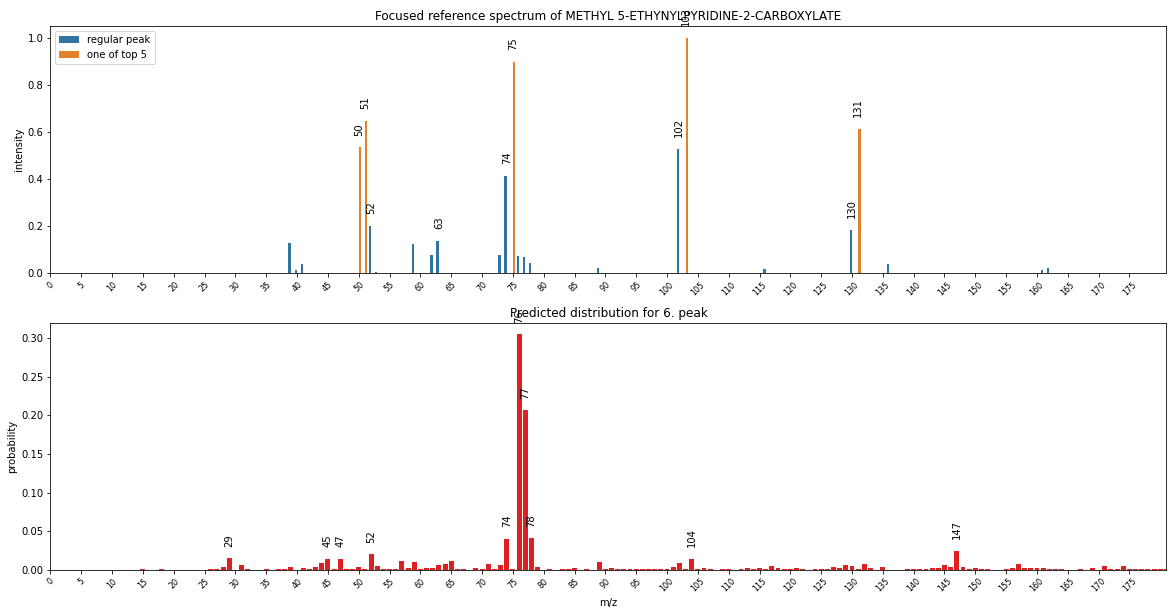

In [55]:
plot_spectrum(test_DS_k, best_model, 10, 200)

## Prediction
- Teacher forcing generation
    - generate sequence of predefined lenght using teacherforcing
    - teacher forcing == feed model reference peaks
    - can be used as well as given k, predict k+1th
- Autoregressive generation 
    - generate sequence of predefined lenght using teacherforcing
    - feed model a k starter peaks using teacher forcing, then feed the model its own last prediciton 
    - TODO - implement temperature
    - TODO - allow batching to speed up computation 
- Usage of predicted distribution after k starter peaks
    - feed model a k starter peaks using teacher forcing, then get the distribution predicted
    - take the top n predicted peaks in distribution

In [56]:
def predict_next(model, X, device, init_state=None):
    model.eval()
    model.to(device)
    with torch.no_grad():
        X = X.to(device)
        log_pred, state = model(X, return_sequence=False, init_state=init_state)
 
    return log_pred, state

def predict_sequence(model, X, device, golden_indices):
    """
        predicts sequence of same length as each input sequence
        
        Peaks on golden_indeces indeces are fed into the model first, 
        then autoregressive self-feeding is used
    """
    
    # currently only works for batch_size = 1
    if X.shape[0] != 1:
        print(X.shape)
        raise ValueError
  
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        # encode the golden 
        X = X.to(device)
        
        log_pred, state = model(X[:, golden_indices[-1]], return_sequence=True) 
        
        y_logprob_seq = log_pred[0]
        y_pred_seq = torch.argmax(log_pred, axis=-1)[0]
        y_pred = y_pred_seq[-1]
    
    if model.add_intens:
        last_intens = X[0,-1,-1]
        
    # predict the rest     
    for i in range(len(y_pred_seq), len(X[0])):
        auto_X = y_pred.reshape(1,-1)
        
        if model.add_intens:
            last_intens = last_intens**.9
            auto_X = torch.tensor((y_pred, last_intens)).reshape(1,-1,2)

        log_pred, state = predict_next(model, auto_X, device, init_state=state)
        y_pred = torch.argmax(log_pred, axis=-1)

        y_logprob_seq = torch.cat((y_logprob_seq, log_pred))
        y_pred_seq = torch.cat((y_pred_seq, y_pred))
    
    if model.add_intens:
        X,_ = X[:,:,0].int(), X[:,:,1]
    return y_pred_seq.reshape(1, *y_pred_seq.shape),  y_logprob_seq.reshape(1, *y_logprob_seq.shape), X[:, golden_indices[-1]]


def predictDS_one(model, k_DS, device, return_cpu=True):
    loader = DataLoader(k_DS, batch_size=128, shuffle=False, num_workers=8)
    all_pred = []
    all_y = []
    
    for b ,(X, y) in enumerate(loader):
        log_pred, _ = predict_next(model, X, device)
        y_pred = torch.argmax(log_pred, axis=-1)
        if return_cpu:
            y_pred, y = y_pred.to("cpu"), y.to("cpu")
          
        all_pred.append(y_pred)
        all_y.append(y)
    return np.array(all_pred).ravel(), np.array(all_y).ravel()

def predictDS_sequence_tf(model, gen_DS, device, return_cpu=True):
    gen_DS.onehot = isinstance(model, PureLSTM)
    gen_DS.add_intensity=model.add_intens
    
    loader = DataLoader(gen_DS, batch_size=32, shuffle=False, num_workers=8, collate_fn=gen_collate)
    
    all_logprob = []
    all_pred = []
    all_y = []
    
    model.eval()
    model.to(device)
    
    for b ,(X, y) in enumerate(loader): 
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            log_pred, _ = model(X, return_sequence=True)
        y_logprob_seq = log_pred
        y_pred_seq = torch.argmax(log_pred, axis=-1)
        
        #all_pred.append(y_pred_seq)
        #all_y.append(y)
        
        # create a list of sequences (regardless batch size)
        for y_pred, y_logprob, y_ in zip(y_pred_seq, y_logprob_seq, y):
            if return_cpu:
                y_pred, y_logprob, y_ = y_pred.to("cpu"), y_logprob.to("cpu"), y_.to("cpu")
          
            padding_mask = y_ != -100
            all_pred.append(y_pred[padding_mask[:len(y_pred)]])
            all_y.append(y_[padding_mask])
            all_logprob.append(y_logprob[padding_mask[:len(y_pred)]])    
    return all_pred, all_logprob, all_y 

def predictDS_sequence(model, gen_DS, device, k=5, mode="top", y_fixed=True, return_cpu=True):
    gen_DS.onehot = isinstance(model, PureLSTM)
    gen_DS.add_intensity=model.add_intens
    
    loader = DataLoader(gen_DS, batch_size=1, shuffle=False, num_workers=8, collate_fn=gen_collate)
    all_logprob = []
    all_pred = []
    all_y = []
    all_used_X = []
    
    
    for b ,(X, y) in enumerate(loader):
        
        # check if shortest sequence in batch is longer than k, else skip 
        if min(map(len, X)) < k:
            continue
        
        
        if mode=="top":
            golden_indices = np.repeat(np.arange(k).reshape(1,-1), len(X),axis=0)
        
        y_pred_seq, y_logprob_seq, used_X_batch = predict_sequence(model, X, device, golden_indices)
        
        # create a list of sequences (regardless batch size)
        for y_pred, y_logprob, y_, used_X in zip(y_pred_seq, y_logprob_seq, y, used_X_batch):
            if return_cpu:
                y_pred, y_logprob, y_, used_X = y_pred.to("cpu"), y_logprob.to("cpu"), y_.to("cpu"), used_X.to("cpu")
            
            all_used_X.append(used_X)
            # fix first k labels in labels and predictions to 0
            if y_fixed:
                all_y.append(torch.cat((torch.zeros(k-1, dtype=int),y_[k-1:])))
                probs_fix = torch.zeros_like(y_logprob[:k-1])
                probs_fix[:, 0] += 1
                all_logprob.append(torch.cat((torch.log(probs_fix),y_logprob[k-1:])))
                all_pred.append(torch.cat((torch.zeros(k-1, dtype=int),y_pred[k-1:])))
            
            else:
                all_y.append(y_)
                all_logprob.append(y_logprob)
                all_pred.append(y_pred)
            
    return all_pred, all_logprob, all_y, all_used_X

## Evaluation
Proper quantitative evaluation of the trained spectral models  

* TODO -MAP weighted by intensity
* TODO - KL divergence (=categorical cross entrophy) metric between the rest peaks and predicted distribution (especially for "given top_k, predict all the rest" task) 
* Accuracy of predicting the k+1th peak (especially for "given top_k, predict k+1th" task)
* Set stats - Precision, Leftover_ratio, Harmonic Mean, Jaccard

In [57]:
# get predictions


# all_y_tf are all peaks 
# teacher forcing (given k,predict 1, all k)
all_pred_tf, all_logprob_tf, all_y_tf = predictDS_sequence_tf(best_model, test_DS, device)


# get dummy predictions
all_pred_dummy, all_logprob_dummy, _ = predictDS_sequence_tf(dummy, test_DS, device)

all_pred_dummy_pk, all_logprob_dummy_pk, _ = predictDS_sequence_tf(dummy_per_k, test_DS, device)


# extract intensities
all_intensities = []
test_DS.add_intensity = True
for i in range(len(test_DS)):
    seq, y = test_DS[i]
    # safety check that intensities are well aligned
    if any(y != all_y_tf[i].to("cpu")):
        raise ValueError
            
    intensities = seq[:,-1]
    all_intensities.append(intensities)
test_DS.add_intensity=best_model.add_intens


# get autoreg and distrib predictions with k starters
def get_k_preds(best_model, test_DS, device, base_model=None, k=5, mode="top", y_fixed=True):

    # all_y_ are trimmed peaks starting at kth one 
    # auregressive generation given k (given k, predict rest)
    all_pred , all_logprob, all_y, all_used_X = predictDS_sequence(best_model, test_DS, device, k=k, mode="top", y_fixed=y_fixed)
        
    # distribution given k (given k, predict dst for k+1h, extract rest n_peaks)
    # remove [:len(y)] cut to allow longer predictions
    all_pred_dst = [torch.cat((torch.zeros(k-1, dtype=int),torch.argsort(logprob[k-1], descending=True)))[:len(y)] for logprob, y in zip(all_logprob, all_y)]
    
    # show also base model predictions
    if base_model is not None:
        all_pred_base, all_logprob_base, _, _ = predictDS_sequence(base_model, test_DS, device, k=k, mode="top", y_fixed=y_fixed)
        return all_pred , all_logprob, all_y, all_pred_dst, all_used_X, all_pred_base, all_logprob_base
    
    return all_pred , all_logprob, all_y, all_pred_dst, all_used_X



k=5

%time all_pred , all_logprob, all_y, all_pred_dst, all_used_X = get_k_preds(best_model, test_DS, device, base_model=None, k=k, mode="top")


CPU times: user 1min 34s, sys: 2.67 s, total: 1min 36s
Wall time: 1min 40s


In [58]:
print(len(all_pred_tf[0]))
print(len(all_pred_dummy[0]))
print(len(all_pred[0]))
print(len(all_pred_dst[0]))

470
470
470
470


In [59]:
print(all_pred_dst[0][3],all_pred_dst[0][4])
print(all_pred[0][3],all_pred[0][4])


print(all_pred_dst[0][3],all_pred_dst[0][5])
print(all_pred[0][3],all_pred[0][5])


print(all_used_X[0])


tensor(0) tensor(24)
tensor(0) tensor(24)
tensor(0) tensor(15)
tensor(0) tensor(19)
tensor([51, 10, 55, 17, 44], dtype=torch.int32)


##### Correctness tests:

In [60]:
# test that tf and autoreg are the same in starters
seq_test = []
for i in range(len(all_pred)):
    seq_test.append(all((all_pred_tf[i][:k] == all_pred[i][:k])))
all(seq_test) # should be false now

False

In [61]:
# test that tf and autoreg are not the same all the time
seq_test = []
for i in range(len(all_pred)):
    seq_test.append(any((all_pred_tf[i] != all_pred[i])))   
any(seq_test) 

True

In [62]:
# test that tf and autoreg probs are the same in starters
seq_test = []
for i in range(len(all_logprob)):
    seq_test.append(all(((all_logprob_tf[i][:k] - all_logprob[i][:k]).abs() < 1e-5).ravel()))
all(seq_test) # should be false now

False

In [63]:
# test that y tf and y autoreg are the same begining at k
seq_test = []
for i in range(len(all_y)):
    seq_test.append(all((all_y[i][k:] == all_y_tf[i][k:])))
all(seq_test) # should be true now

True

In [64]:
len(all_pred), len(all_y)

(1818, 1818)

In [65]:
len(all_pred[0]), len(all_y[0])

(470, 470)

In [66]:
sns.set_theme()

def plot_stats(data1D, baseline1D=None, max_len=None, title=None, log_y=False, color="blue", decreasing=False, ylim=None, ylabel=None, xlabel=None, x_factor=1):
    plt.figure(figsize=(20,10))
    if title:
        plt.title(title)
    if max_len is None:
        max_len = len(data1D)
        
    x = np.arange(max_len)*x_factor
    
    
    if baseline1D is not None:
        ax = sns.scatterplot(y=baseline1D[:max_len], x=x, color="darkgrey")  
        ax = sns.scatterplot(y=data1D[:max_len], x=x, color=color, ax=ax)
    else:
        ax = sns.scatterplot(y=data1D[:max_len], x=x, color=color)
    
    
    if decreasing:
        plt.gca().invert_xaxis()
    if log_y:
        ax.set(yscale="log")
        
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.set(ylabel=ylabel, xlabel=xlabel)
    plt.xticks(ticks=np.arange(0,max_len,10)*x_factor,fontsize=8, rotation=45)
    plt.show()
    
def plot_stats8(datas_3D, base_data=None, max_len=None, titles=None, color=["blue", "blue", "blue", "blue"]):
    fig, axes = plt.subplots(4, 2, figsize=(20,13), sharey="row")
    
    
    #(ax1, ax4, ax3), (ax4, ax5, a6)  = axes 
    for i in range(len(axes)):
        for j in range(len(axes[i])):
            if max_len is None:
                max_len = len(datas_3D[j][i])
            
            x = np.arange(max_len)
    
            if base_data is not None:
                axes[i][j] = sns.scatterplot(y=base_data[i][:max_len], x=x, color="darkgrey", ax=axes[i][j])  
                axes[i][j] = sns.scatterplot(y=datas_3D[j][i][:max_len], x=x, color=color[i], ax=axes[i][j])

            axes[i][j] = sns.scatterplot(y=datas_3D[j][i][:max_len], x=x, color=color[i], ax=axes[i][j])

            
               # ax = sns.scatterplot(y=data1D[:max_len], x=x, color=color)

            
            plt.sca(axes[i][j])    
            plt.xticks(ticks=np.arange(0,max_len,10),fontsize=8, rotation=45)

            if titles:
                plt.title(titles[j][i])
 
    plt.tight_layout(pad=0.3, w_pad=0.4, h_pad=0.5)
    
    
    plt.show()
    

### Occurence counter
 - Inspect the occurence of peaks in spectra

In [67]:
from collections import Counter
def get_occurence(ds):
    all_ = []
    for i in range(len(ds)):
        all_ += [*map(lambda p: int(p.split("@")[1]), ds.ref_docs[i].words)]
    return all_, Counter(all_)
all_, occurences = get_occurence(test_DS)
locations, counts = np.array(sorted(zip(occurences.keys(), occurences.values() ), key=lambda x: x[0])).T
occurences.most_common(10),  min(all_), max(all_)

([(43, 911),
  (91, 901),
  (105, 869),
  (85, 868),
  (55, 863),
  (41, 855),
  (77, 794),
  (39, 793),
  (89, 753),
  (115, 748)],
 1,
 940)

### Total@k, Int@k
- Total@k: Statistics to get better insight into the total number of peaks on k-position in all spectra
- Int@k: Statistics to get better insight into the mean intensity of peaks on k-position in all spectra

In [68]:
def int_at_k(all_intensities):
    max_len = max(map( len, all_intensities))
    sum_ = np.zeros(max_len)
    counts = np.zeros(max_len)
    for intensities in all_intensities:
        for j, inten in enumerate(intensities):
            sum_[j] += inten
            counts[j] += 1
    mean_inten_at_k = sum_/counts
    return mean_inten_at_k
mean_int_at_k = int_at_k(all_intensities)
mean_int_at_k[:10], mean_int_at_k[-10:]

(array([1.        , 0.57027059, 0.39523965, 0.29932095, 0.23927682,
        0.19886774, 0.16781715, 0.14494701, 0.12684109, 0.11262036]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### Accuracy@k
- accuracy of predicting k+1th peak given k most intense 

In [69]:
def accuracy_at_k(all_pred, all_y):
    max_len = max(map( len, all_y))
    correct = np.zeros(max_len)
    total = np.zeros(max_len)
    for p, y in zip(all_pred, all_y):
        for i in range(len(p)):
            total[i] +=1
            if p[i] == y[i]:
                correct[i] +=1
    acc = correct/total 
    return acc, total , correct
accs_at_k, total_at_k, correct_at_k = accuracy_at_k(all_pred_tf, all_y_tf)
accs_at_k_dummy, _, _ = accuracy_at_k(all_pred_dummy, all_y_tf)
accs_at_k[:10], accs_at_k[-10:], total_at_k[:10], total_at_k[-10:]

(array([0.13366337, 0.15511551, 0.17216722, 0.16611661, 0.16611661,
        0.15786579, 0.13586359, 0.1430143 , 0.11936194, 0.12520776]),
 array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]),
 array([1818., 1818., 1818., 1818., 1818., 1818., 1818., 1818., 1818.,
        1805.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [70]:
def loss_at_k(all_logprob, all_y):
    max_len = max(map( len, all_y))
    loss_sum = np.zeros(max_len)
    total = np.zeros(max_len)
    for p, y in zip(all_logprob, all_y):
        p = p.cpu()
        y =y.cpu()
        for i in range(len(p)):
            total[i] +=1
            loss_sum[i] += torch.nn.functional.nll_loss(p[i].reshape(1,-1), y[i].reshape(1))
    loss = loss_sum/total 
    return loss, np.exp(-loss)
nlll_at_k, likelihood_at_k = loss_at_k(all_logprob_tf, all_y_tf)
nlll_at_k_dummy, likelihood_at_k_dummy = loss_at_k(all_logprob_dummy, all_y_tf)

nlll_at_k[:10], nlll_at_k[-10:], likelihood_at_k[:10], likelihood_at_k[-10:]

(array([4.3883716 , 4.14665627, 4.01994513, 4.04188529, 4.01564729,
        4.0815051 , 4.14574014, 4.04633542, 4.21429907, 4.17856865]),
 array([5.19662094, 4.7037344 , 4.22073317, 4.45432663, 3.83331299,
        3.96383548, 4.44789124, 4.4105587 , 4.72388458, 6.34498978]),
 array([0.01242094, 0.01581722, 0.01795395, 0.01756433, 0.01803128,
        0.01688204, 0.01583171, 0.01748634, 0.01478268, 0.01532042]),
 array([0.00553524, 0.00906138, 0.01468787, 0.01162815, 0.02163781,
        0.01899014, 0.01170322, 0.01214839, 0.00888061, 0.00175552]))

### Accuracy@int
- accuracy of predicting correct next peak when the correct peak shall be on given intesity level 

In [71]:
def accuracy_at_int(all_pred, all_y, granularity, skip_k=0):
    max_len = int(1/granularity)
    correct = np.zeros(max_len+1)
    total = np.zeros(max_len+1)
    for p, y, inten in zip(all_pred, all_y, all_intensities):
        for i in range(skip_k, len(p)):
            #print(inten[i])
            total[int(inten[i]*max_len)] +=1
            if p[i] == y[i]:
                correct[int(inten[i]*max_len)] +=1
    acc = correct/total 
    return acc, total, correct

accs_at_int, total_at_int, correct_at_int = accuracy_at_int(all_pred_tf, all_y_tf, .01, skip_k=0)
accs_at_int_dummy, _, _ = accuracy_at_int(all_pred_dummy, all_y_tf, .01, skip_k=0)

accs_at_int[:10], accs_at_int[-10:], total_at_int[:10], total_at_int[-10:]

(array([0.01898879, 0.04026579, 0.05643419, 0.06277792, 0.06826604,
        0.06598852, 0.07788864, 0.08183556, 0.09718438, 0.10645724]),
 array([0.2       , 0.15384615, 0.08695652, 0.2       , 0.33333333,
        0.16666667, 0.21052632, 0.26666667, 0.07407407, 0.13366337]),
 array([48239., 20166., 11571.,  7646.,  5127.,  3834.,  3107.,  2615.,
         2202.,  1719.]),
 array([  25.,   26.,   23.,   25.,   15.,   24.,   19.,   15.,   27.,
        1818.]))

## <center> SECTION 0: Test dataset stats </center> 

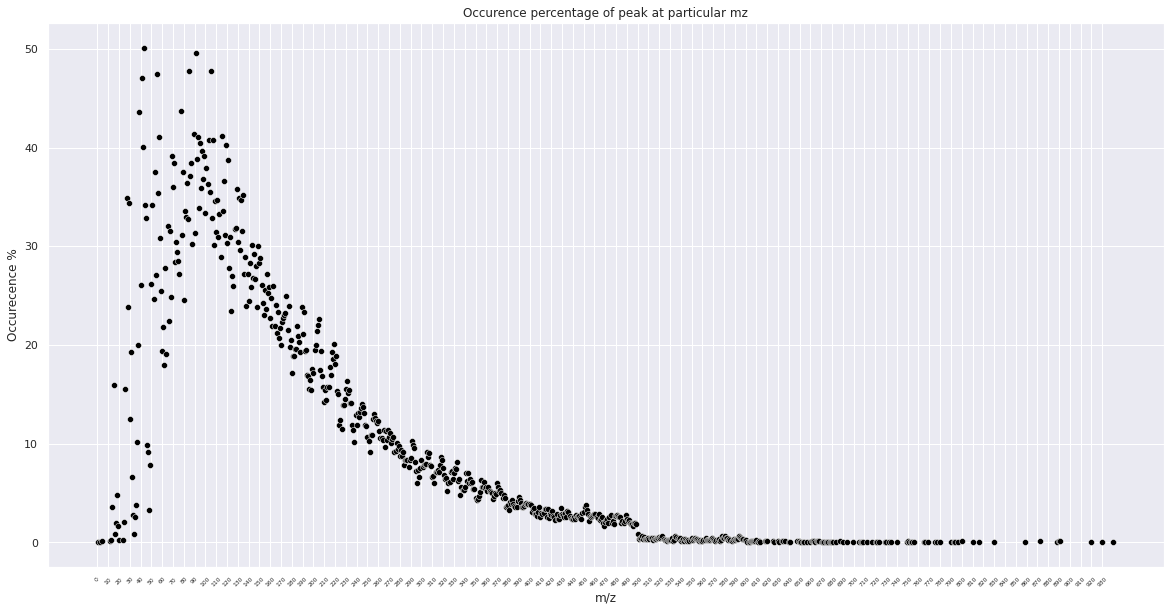

In [72]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x=locations, y=counts/len(test_DS)*100, color="black")
plt.xticks(ticks=np.arange(0,max(locations),10), fontsize=6, rotation=45)
plt.title("Occurence percentage of peak at particular mz")
ax.set(ylabel='Occurecence %', xlabel='m/z')
None

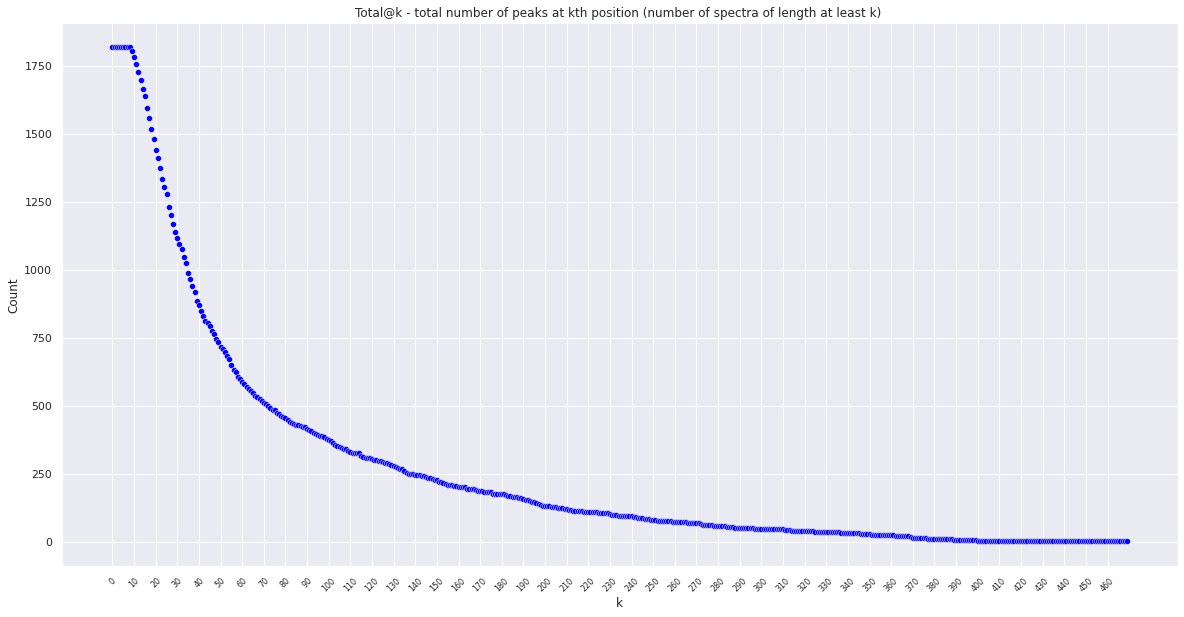

In [73]:
plot_stats(total_at_k, title="Total@k - total number of peaks at kth position (number of spectra of length at least k) ", ylabel='Count', xlabel='k')

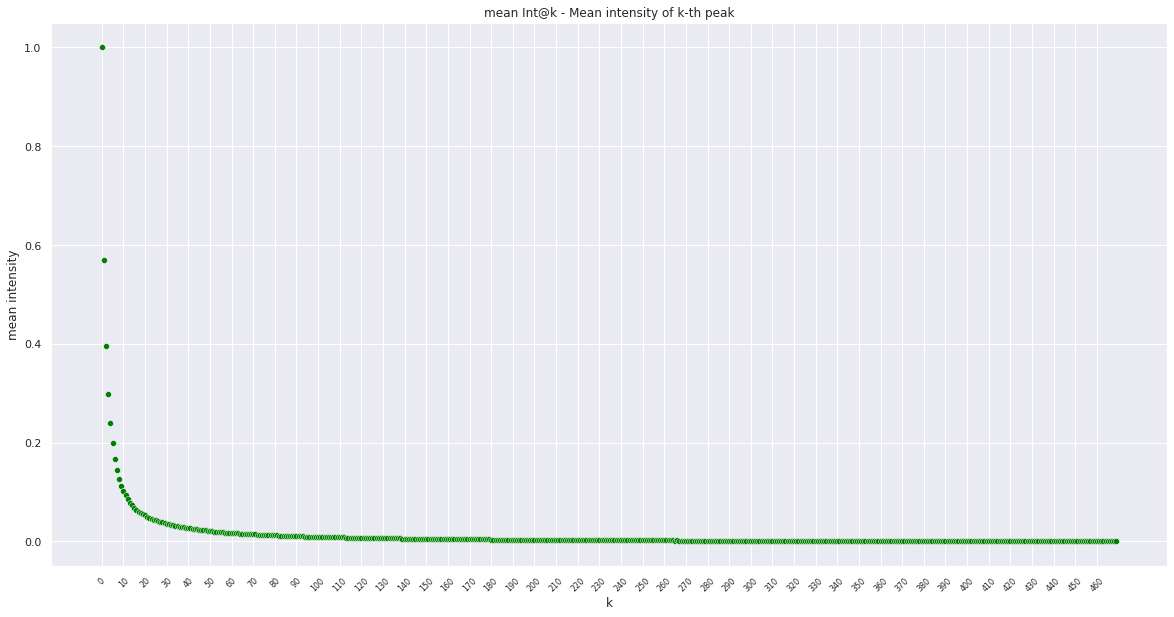

In [74]:
plot_stats(mean_int_at_k, title="mean Int@k - Mean intensity of k-th peak", color="green", ylabel='mean intensity', xlabel='k')

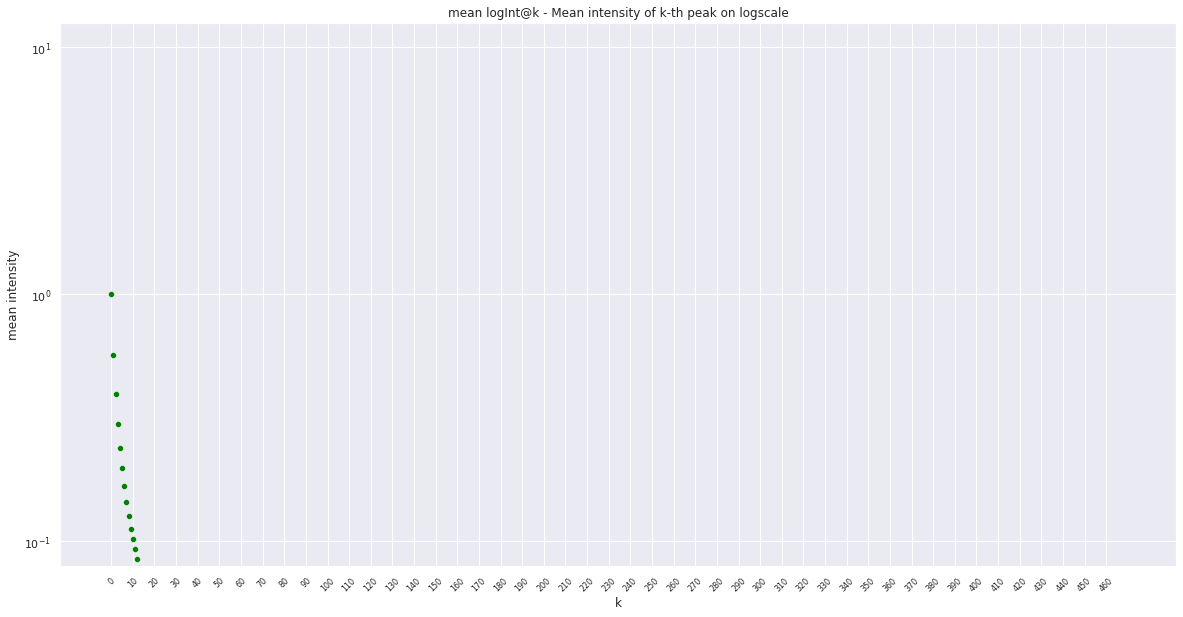

In [75]:
plot_stats(mean_int_at_k, title="mean logInt@k - Mean intensity of k-th peak on logscale", log_y=True, color="green",ylabel='mean intensity', xlabel='k' )

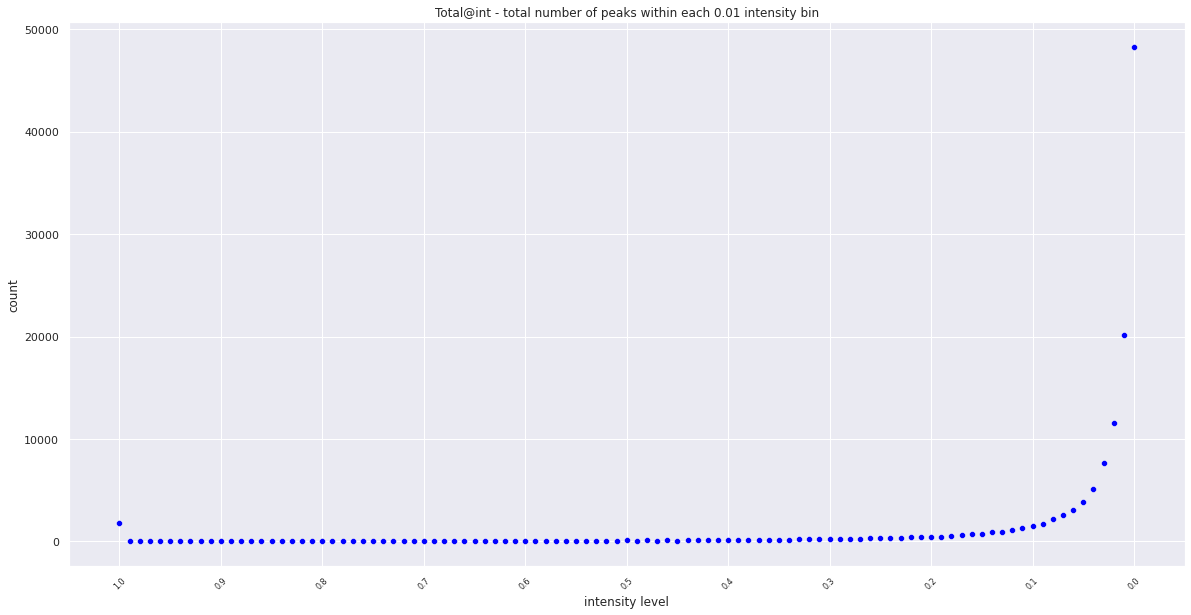

In [76]:
plot_stats(total_at_int, title="Total@int - total number of peaks within each 0.01 intensity bin", decreasing=True, ylabel='count', xlabel='intensity level', x_factor=0.01)

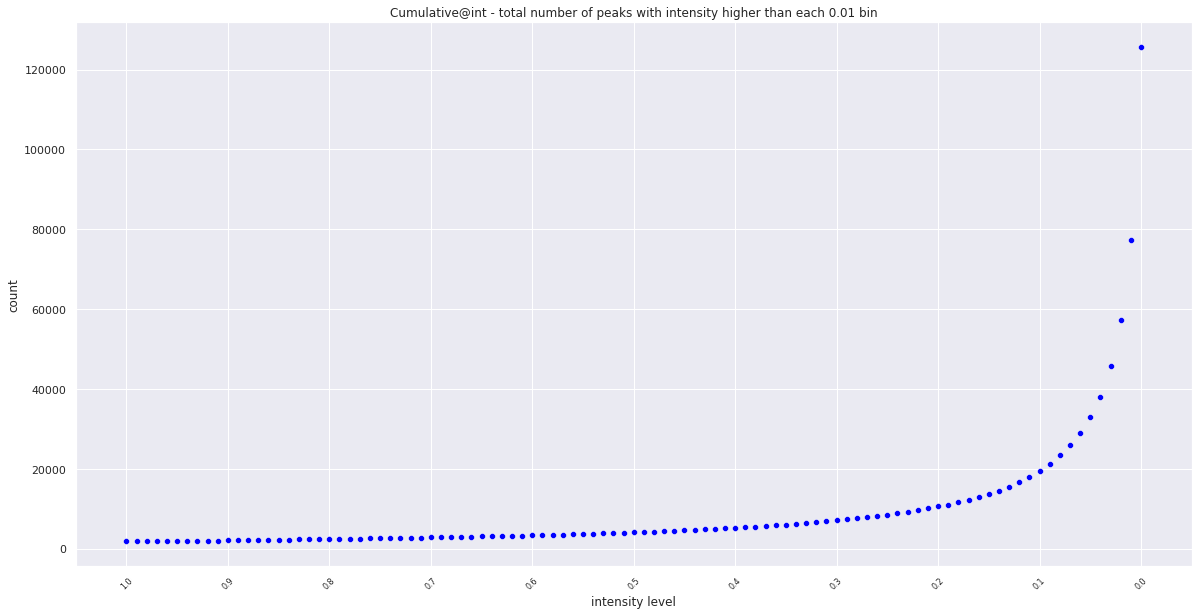

In [77]:
plot_stats(np.cumsum(total_at_int[::-1])[::-1], title="Cumulative@int - total number of peaks with intensity higher than each 0.01 bin", decreasing=True, ylabel='count', xlabel='intensity level', x_factor=0.01)

TODO cummulative int (n peaks at cum intensity level)
TODO check isotopes filtering in MONA

----------
# <span style="color:red"> --------------------------------------------- BIG RED LINE --------------------------------------------</span>
----------------
## <center> SECTION 1: Predict one </center>
**....All the graphs showing scenario given k, predict one next peak; visualize over all k.**

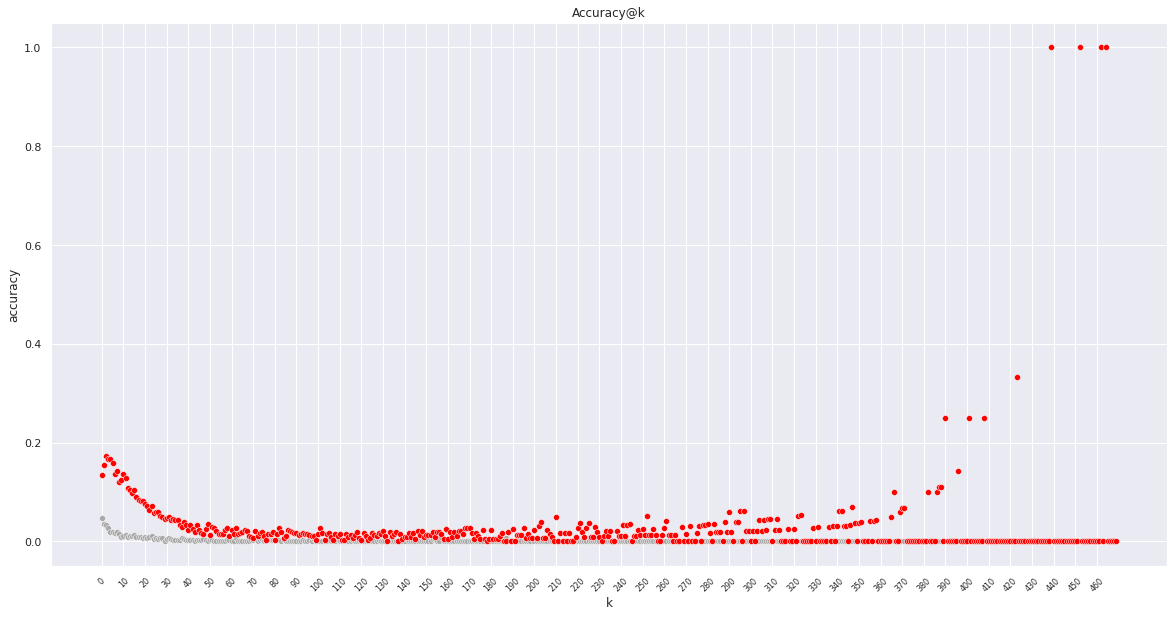

In [78]:
plot_stats(accs_at_k, baseline1D=accs_at_k_dummy, title="Accuracy@k", color="red", ylabel='accuracy', xlabel='k')

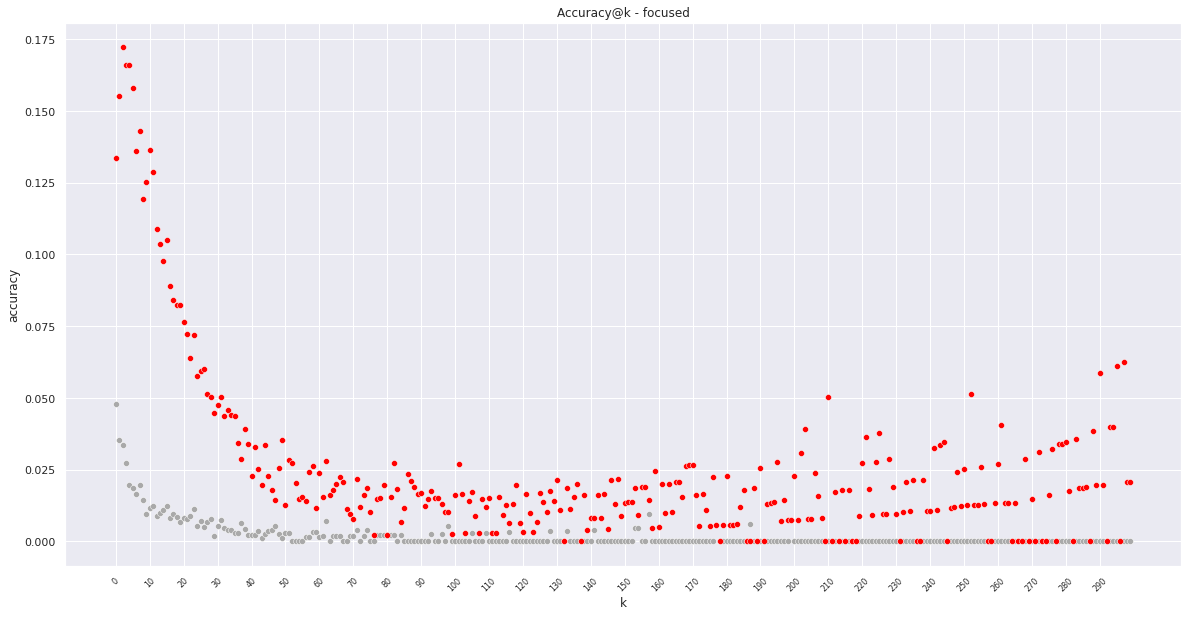

In [79]:
plot_stats(accs_at_k, baseline1D=accs_at_k_dummy, title="Accuracy@k - focused", max_len=300, color="red",  ylabel='accuracy', xlabel='k')

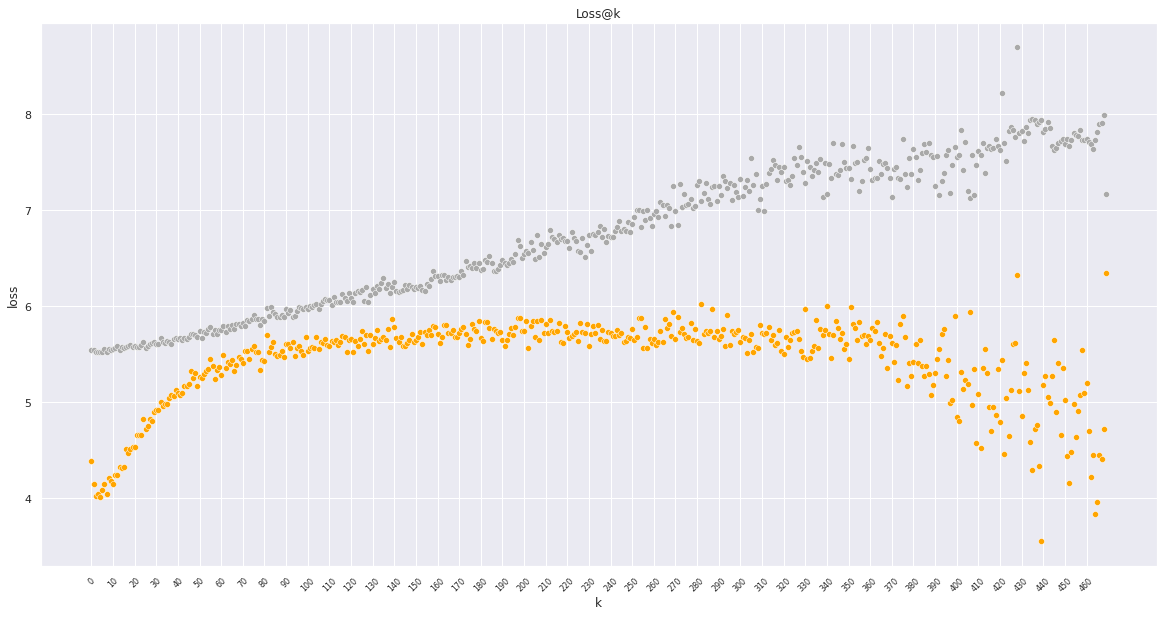

In [80]:
plot_stats(nlll_at_k, baseline1D=nlll_at_k_dummy, title="Loss@k", color="orange",  ylabel='loss', xlabel='k')

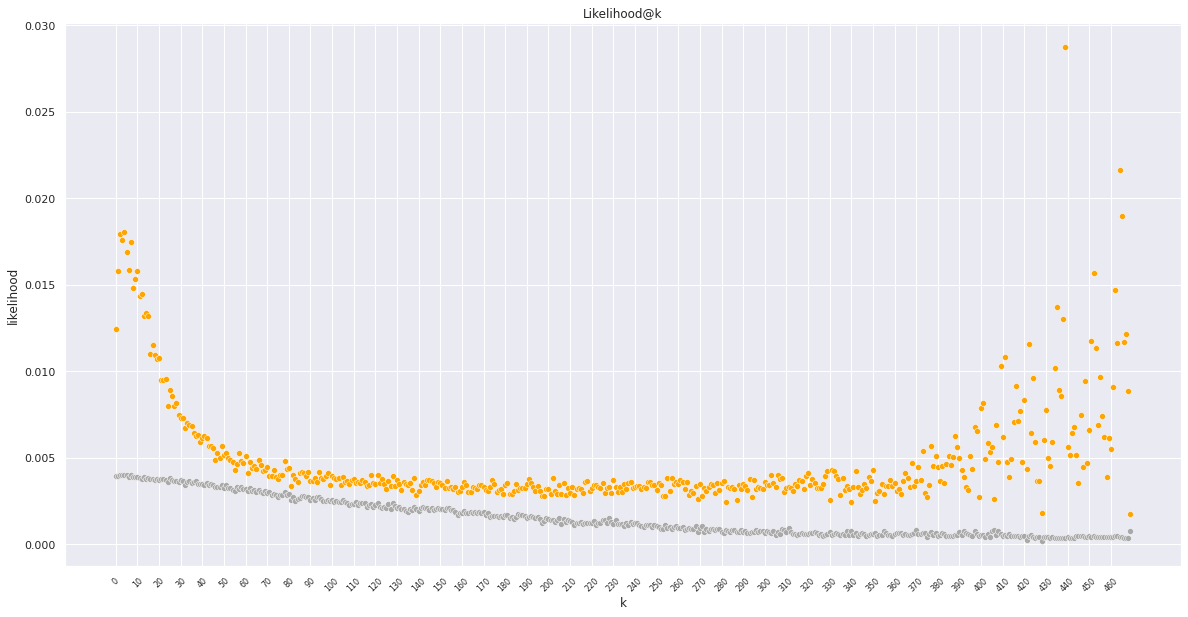

In [81]:
plot_stats(likelihood_at_k, baseline1D=likelihood_at_k_dummy, title="Likelihood@k", color="orange",  ylabel='likelihood', xlabel='k')

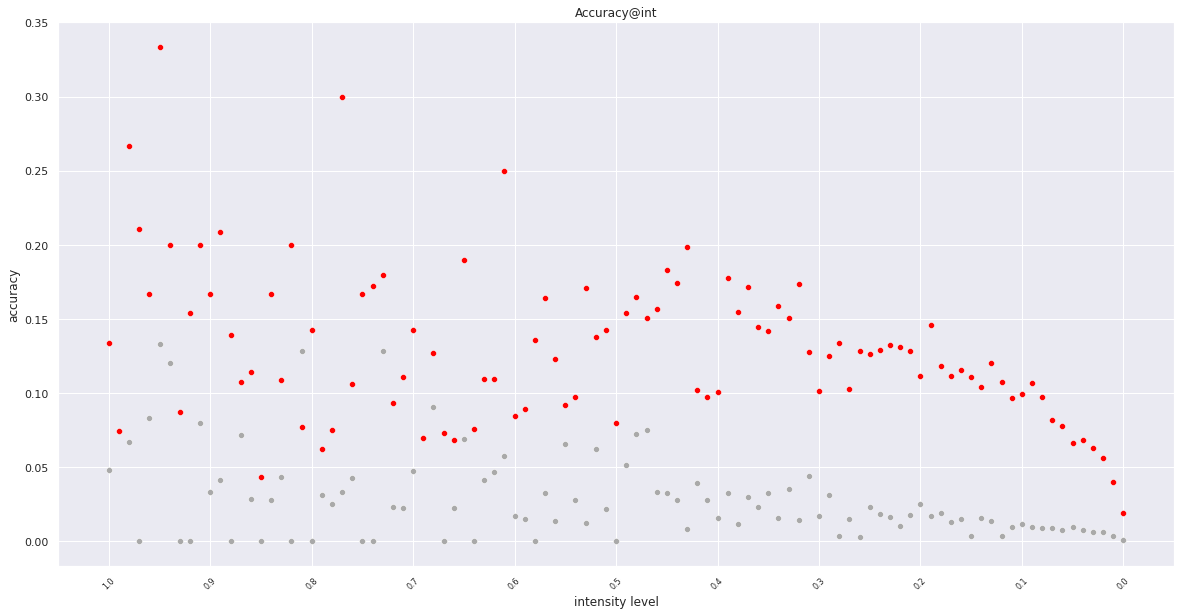

In [82]:
plot_stats(accs_at_int, baseline1D=accs_at_int_dummy, title="Accuracy@int", color="red", decreasing=True,  ylabel='accuracy', xlabel='intensity level', x_factor=.01)

----------
# <span style="color:red"> --------------------------------------------- BIG RED LINE --------------------------------------------</span>
----------------
## <center> SECTION 2: Predict many </center>
**....From now on, all the graphs showing scenario given k, predict many rest peaks.**

### Autoregressive (given 5) accuracy, loss 

In [83]:
accs_at_k_gen, total_at_k_gen, correct_at_k_gen = accuracy_at_k(all_pred, all_y)
nlll_at_k_gen, likelihood_at_k_gen = loss_at_k(all_logprob, all_y)
accs_at_int_gen, _, correct_at_int_gen = accuracy_at_int(all_pred, all_y, .01, skip_k=5)

<ipython-input-71-cfa2f0cb7864>:11: RuntimeWarning: invalid value encountered in true_divide
  acc = correct/total


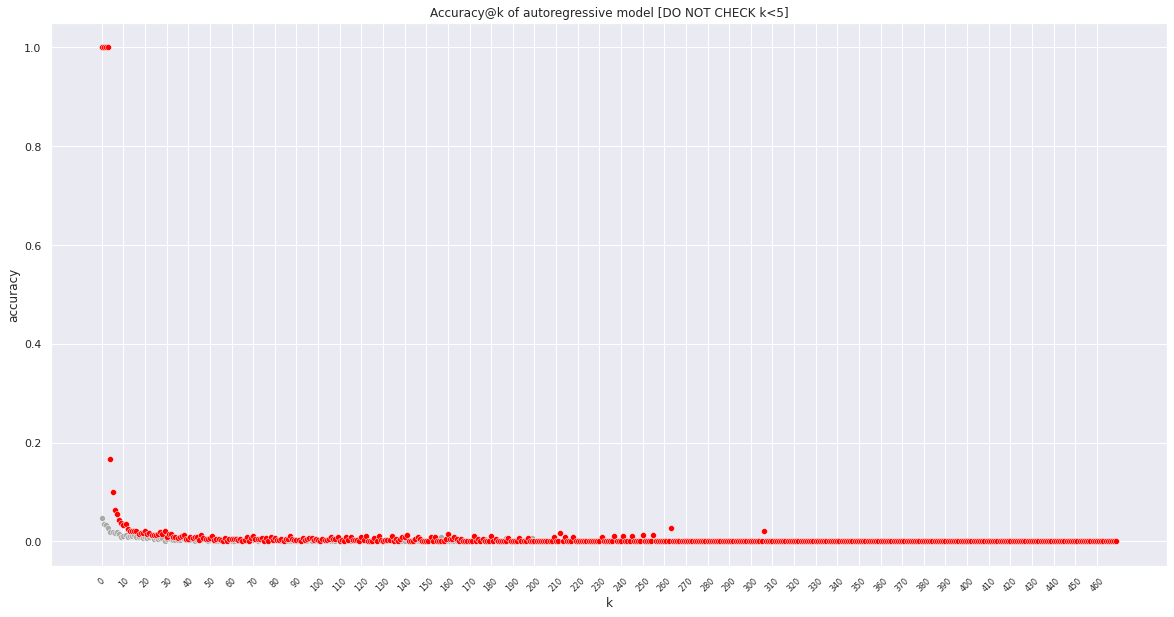

In [84]:
plot_stats(accs_at_k_gen, baseline1D=accs_at_k_dummy,  title="Accuracy@k of autoregressive model [DO NOT CHECK k<5]", color="red", ylabel='accuracy', xlabel='k')

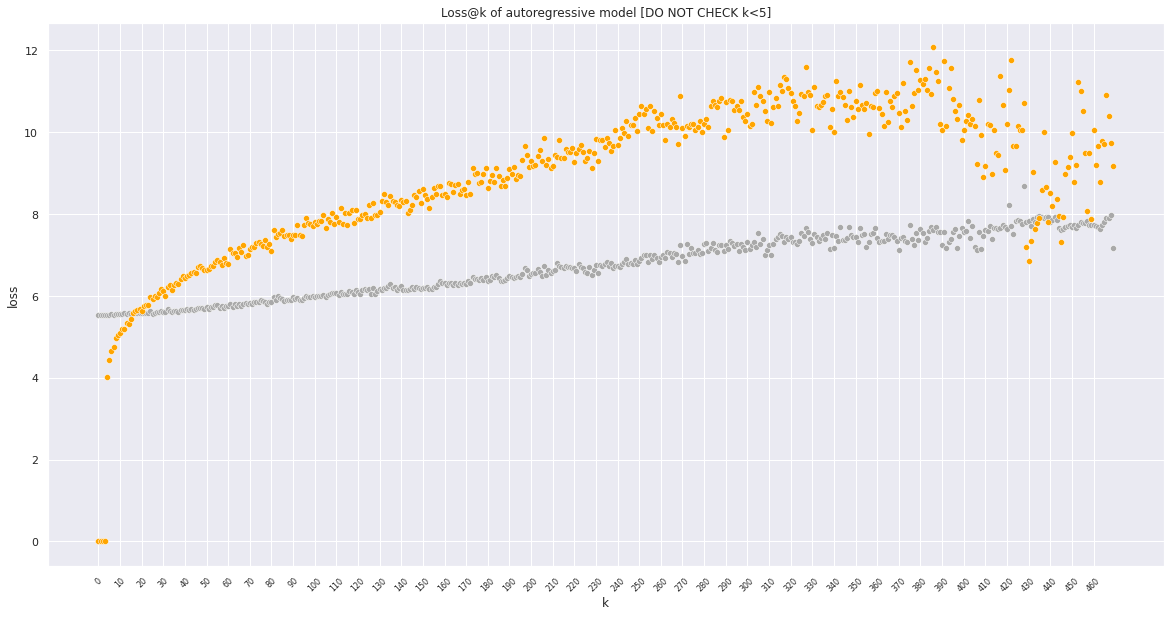

In [85]:
plot_stats(nlll_at_k_gen, baseline1D=nlll_at_k_dummy, title="Loss@k of autoregressive model [DO NOT CHECK k<5]", color="orange",  ylabel='loss', xlabel='k')

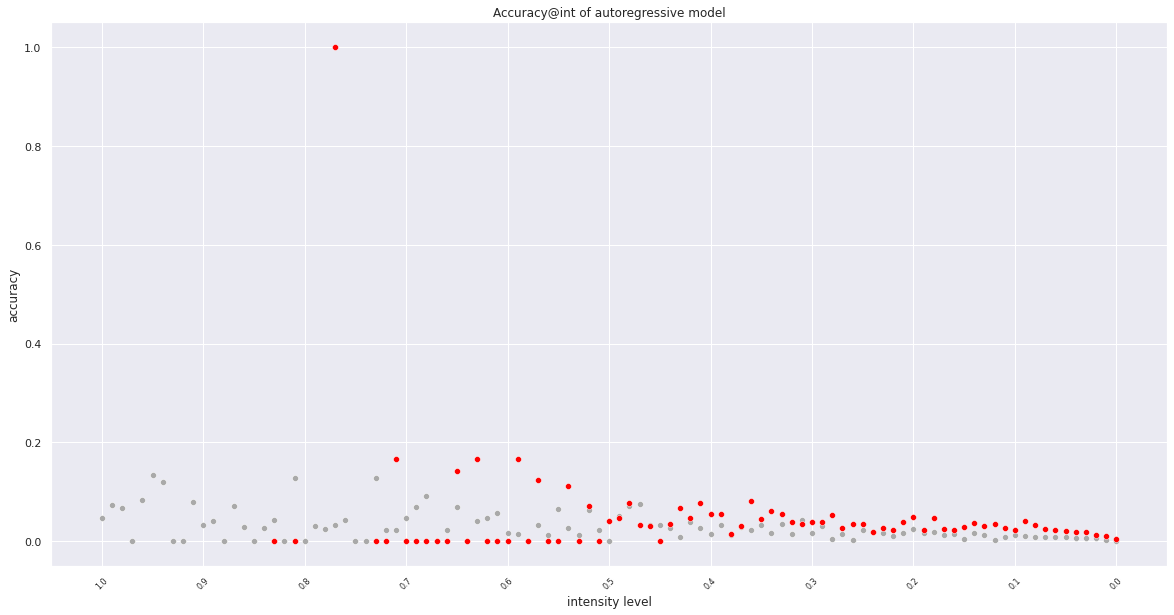

In [86]:
plot_stats(accs_at_int_gen, baseline1D=accs_at_int_dummy, title="Accuracy@int of autoregressive model", color="red", decreasing=True, ylim=(-0.05,1.05),  ylabel='accuracy', xlabel='intensity level', x_factor=.01)

### Distribution (given 5) accuracy 

In [87]:
accs_at_k_dst, total_at_k_dst, correct_at_k_dst = accuracy_at_k(all_pred_dst, all_y)
#nlll_at_k_gen, likelihood_at_k_gen = loss_at_k(all_logprob_dst, all_y_dst)
accs_at_int_dst, _, correct_at_int_dst = accuracy_at_int(all_pred_dst, all_y, .01, skip_k=5)

<ipython-input-71-cfa2f0cb7864>:11: RuntimeWarning: invalid value encountered in true_divide
  acc = correct/total


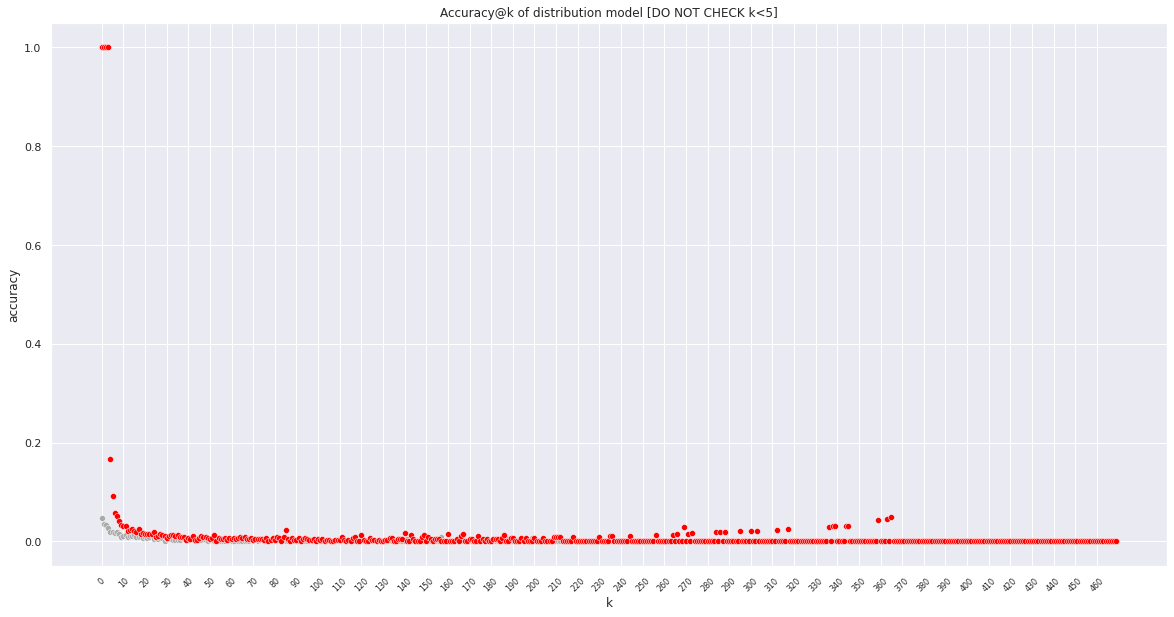

In [88]:
plot_stats(accs_at_k_dst, baseline1D=accs_at_k_dummy, title="Accuracy@k of distribution model [DO NOT CHECK k<5]", color="red", ylabel='accuracy', xlabel='k')

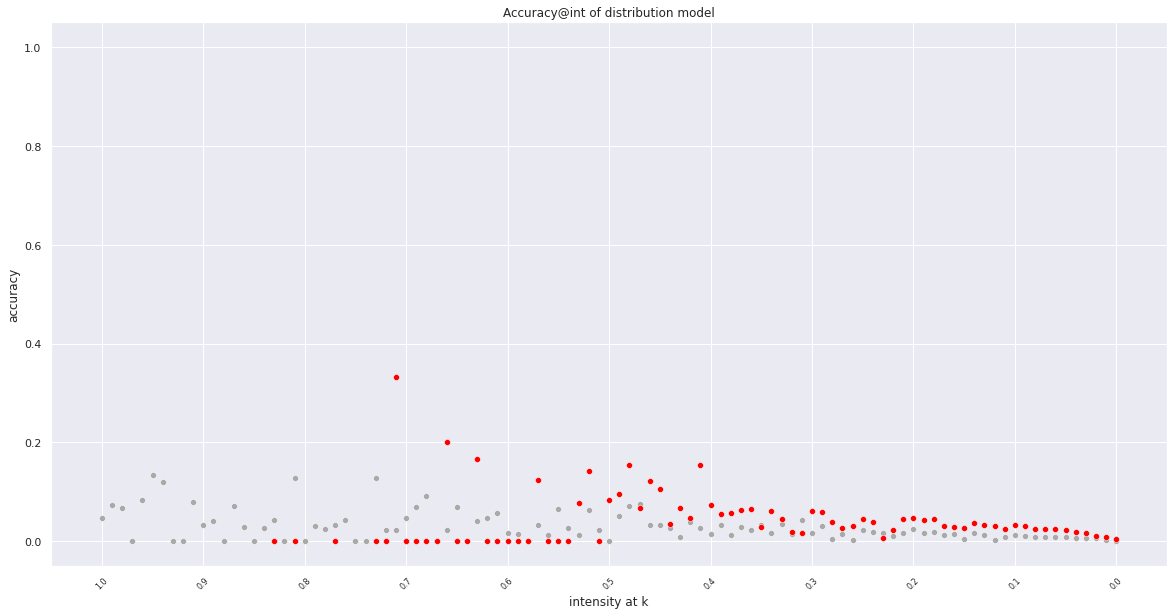

In [89]:
plot_stats(accs_at_int_dst, baseline1D=accs_at_int_dummy,  title="Accuracy@int of distribution model", color="red", decreasing=True, ylim=(-0.05,1.05),  ylabel='accuracy', xlabel='intensity at k', x_factor=.01)

### Precison, leftover ratio, Harmonic mean, Jaccard

Measure model prediction regradless its current position
- Predict (generate / obtain) the same amount of peaks as is in the reference spectrum 
- Observe the similarity of these two sets - reference peaks set and predicted peaks set

TODO - If generating -> take in account repetetivy generated peaks


- TP: Predicted peak is in the reference set
- FP: Predicted peak is not in the reference set
- [NOT USED]FN: Peak in the reference set which was not predicted
- [NOT USED]TN: Rest

Metrics:
- Precision: Portion of predicted, filtered peaks that are in reference set
- Leftover_ratio: Portion of original predicted peaks that was kept after filtering
- Jaccard score: 

TODO - take in account the closeness (weight by gaussian centred in the reference peak position?)

TODO - take in account the total sequence len

In [90]:
def get_set_stats(all_pred, all_y, all_used_X):
    all_precisions = np.zeros(len(all_pred))
    all_leftovers_ratio = np.zeros(len(all_pred))
    all_jaccards = np.zeros(len(all_pred))
    for i, (y_pred, y, used_X) in enumerate(zip(all_pred, all_y, all_used_X)):
        y_pred_set = set(y_pred.tolist()).difference(set(used_X))
        y_set = set(y.tolist())
        
        TP = len(y_set.intersection(y_pred_set))
        FP = len(y_pred_set) - TP
        
        set_precision = TP/ (TP + FP) if TP+FP != 0 else np.NaN
        
        set_leftover_ratio = len(y_pred_set)/len(y_pred)
        
        jaccard = TP/ len(y_set.union(y_pred_set))
        
        all_precisions[i] = set_precision
        all_leftovers_ratio[i] = set_leftover_ratio
        all_jaccards[i] = jaccard
    return all_precisions, all_leftovers_ratio, all_jaccards

### Set stats given k
- given k top peaks, predict to_predict peaks, exclude those found in the topk, measure set stats of such prediction compared to the corresponding to_match reference peaks   
- measured by:
    - PrecisionGivenk 
    - LeftoverRatioGivenk
    - JaccardGivenK

In [91]:
def set_stats_given_k(k_all_pred, k_all_y, k_all_used_X, to_predict=None, to_match=None):
    all_precisions_given_k = []
    all_leftovers_ratio_given_k = []
    all_jaccards_given_k = []
    
    for k, (all_pred, all_y, all_used_X) in enumerate(zip(k_all_pred, k_all_y, k_all_used_X)):
        trimmed_all_pred = []
        rest_all_y = []
        for p, y in zip(all_pred, all_y):
            rest = y[k:]
            p = p[k:]
            if to_predict is not None:
                p = p[:to_predict]
                
                # be fair in case that to_predict is larger than predictions and skip this
                if len(p) < to_predict:
                    continue
                    
                    
            if to_match is not None:
                rest = rest[:to_match]
                
                # be fair in case that to_match is larger than ref spectrum and skip this
                if len(rest) < to_match:
                    continue
                
            trimmed_all_pred.append(p)
            rest_all_y.append(rest)
            
        pr, rec, jac = get_set_stats(trimmed_all_pred, rest_all_y, all_used_X)
        all_precisions_given_k.append(pr)
        all_leftovers_ratio_given_k.append(rec)
        all_jaccards_given_k.append(jac)
    return all_precisions_given_k, all_leftovers_ratio_given_k, all_jaccards_given_k



def get_mean_nan(data2D):
    means = np.zeros(len(data2D))
    for i, row in enumerate(data2D):
        mean_ = row[~np.isnan(row)].mean()
        means[i] = mean_
    return means

### TODO - Exploit distributional model uncertainty - Given k, predict many
- get the n largest predicted peaks that together account for XX% of probability mass (n is random variable now), exclude peaks already fed into the model (top k ones)

### REAL USECASE SCENARIO #1
Our peak model detection model working on RT axis (deconvolution) has identified k peaks that are highly probably sure peaks. Now we want to idetify the rest of the peaks that lays in the gray zone. We will feed those peaks according to their intensity descendingly to the model. Model shall predict the rest of the relevant peaks. We are willing to prespecify the number of peaks that we need, but if the model would decide on his own, it would be even better.

**Solution 1: (Autoregressive)**

Assumption: prespecified number of peaks to generate - $n$

Run the model for another $n$ steps, extract $n$ predictions. Output those. 

**Solution 2: (Distribution)**

Variant a)

Assumption: prespecified number of peaks to generate - $n$

Extract the probabilities model has predicted, take top $n$. Output those. 

TODO - Variant b)

Assumption: Required prob mass $m$ hyperparameter specified $m \in [0-1]$

Extract the largest l peaks for which the sum of individaul probabilities is still lower than $m$


**Metrics:**

For each k:

 - If I requested n peaks from model, how much of returned ones really is in the reference set? --> PrecisionGivenk(k, n)
 - I don't really care if model returns peaks I have already fed into it. --> exlude the peaks that are in top_k set from returned before calculating the stats.
     - TODO - But that can hurt recall a lot, right? --> Predict 10*n peaks, exclude those in top_k, return first n of the rest 
 - What if model returns the same peak more times? -> Ignore it 
 - But those filtering above can cause a high precision of useless model that returns only much less relevant peaks than requested -> introduce leftover_ratio
     - ratio of peaks that were left after filtering
 - But I want the model to both return mostly correct peaks and have high leftover ratio! -> consider something as harmonic mean (aka F1) between precision and leftover ratio
 - Jaccard
 
 - TODO But returning relevant but extremely little intense peaks in a place where the most intense (low k) should be returned is also not so good.
     --> TODO - use some weighting of the position (k) where relevant peak was predicted (gausse curve centered at the reference position (k), DCGN = Discounted cumulative gain)?
 - TODO All these are nice, but how good is my neural model than, can you give it a score? --> Weighted sum of F1 scores under chosen objective (next n), weighted by total peaks at such k (maybe slighly smoothed to consider less frequent k == bigger ones too)

#### Variable k 
currently takes extremely long due to not implemented batches in autoregressive prediction 

In [92]:
k_all_pred, k_all_logprob, k_all_y, k_all_pred_dst, k_all_y_dst, k_all_used_X = [],[],[],[],[],[]
k_all_pred_dummy_pk, k_all_logprob_dummy_pk = [], []

In [107]:
%%time
#device="cpu"
for k in range(len(k_all_pred)+1,15):
    print(f"processing k={k} prefix")    
    all_pred, all_logprob, all_y, all_pred_dst, all_used_X, all_pred_dummy_pk, all_logprob_dummy_pk = get_k_preds(best_model, test_DS, device, base_model=dummy_per_k, k=k, mode="top", y_fixed=True)
    
    #all_pred_dummy_pk = all_pred_dummy_pk#torch.cat((torch.zeros(k-1, dtype=int),y_pred[k-1:]))
    #all_logprob_dummy_pk = 

    print(f"Found {len(all_pred)} spectra with len at least {k}")    
    print("-"*50)
    
    k_all_pred.append(all_pred)
    #k_all_logprob.append(all_logprob)
    k_all_y.append(all_y)
    k_all_pred_dst.append(all_pred_dst)
    k_all_used_X.append(all_used_X)
    k_all_pred_dummy_pk.append(all_pred_dummy_pk)
    #k_all_logprob_dummy_pk.append(all_logprob_dummy_pk)
    
    

processing k=10 prefix
Found 1805 spectra with len at least 10
--------------------------------------------------
processing k=11 prefix
Found 1784 spectra with len at least 11
--------------------------------------------------
processing k=12 prefix
Found 1757 spectra with len at least 12
--------------------------------------------------
processing k=13 prefix
Found 1726 spectra with len at least 13
--------------------------------------------------
processing k=14 prefix
Found 1696 spectra with len at least 14
--------------------------------------------------
CPU times: user 8min, sys: 23 s, total: 8min 23s
Wall time: 8min 58s


In [108]:
def compute_stats(k_all_pred, k_all_y, k_all_used_X,to_predict=None, to_match=None):
    all_precisions_given_k, all_ratios_given_k, all_jaccards_given_k = set_stats_given_k(k_all_pred, k_all_y, k_all_used_X, to_predict=to_predict, to_match=to_predict)
    mean_precision_given_k, mean_ratio_given_k, mean_jaccard_given_k = get_mean_nan(all_precisions_given_k), get_mean_nan(all_ratios_given_k), get_mean_nan(all_jaccards_given_k)
    f1_given_k = 2 * mean_precision_given_k * mean_ratio_given_k /(mean_precision_given_k + mean_ratio_given_k)
    return [mean_precision_given_k, mean_ratio_given_k, f1_given_k, mean_jaccard_given_k]

def compute_plot_stats(k_all_pred_left, k_all_pred_right, k_all_y, k_all_used_X, k_all_pred_dummy=None ,names=["left", "right"], to_predict=None, to_match=None):
    data = []
    titles = []
    for name, k_all_pred in zip(names, [k_all_pred_left, k_all_pred_right]):
        titles_col = [f"{met} ({name}; predict {to_predict}, match {to_match})" for met in ["PrecisionGivenk", "RatioGivenk", "HarmonicMean", "Jaccard"]]
        data.append(compute_stats(k_all_pred, k_all_y, k_all_used_X,to_predict=to_predict, to_match=to_match))
        titles.append(titles_col)
    if k_all_pred_dummy is not None:
        dummy_data  = compute_stats(k_all_pred_dummy, k_all_y, k_all_used_X, to_predict=to_predict, to_match=to_match)
    else:
        dummy_data = None
    plot_stats8(data, base_data=dummy_data, titles=titles, color=["black", "olive", "purple", "royalblue"])

#### Test statistics computation by feeding the same set twice - NOT USEFUL!

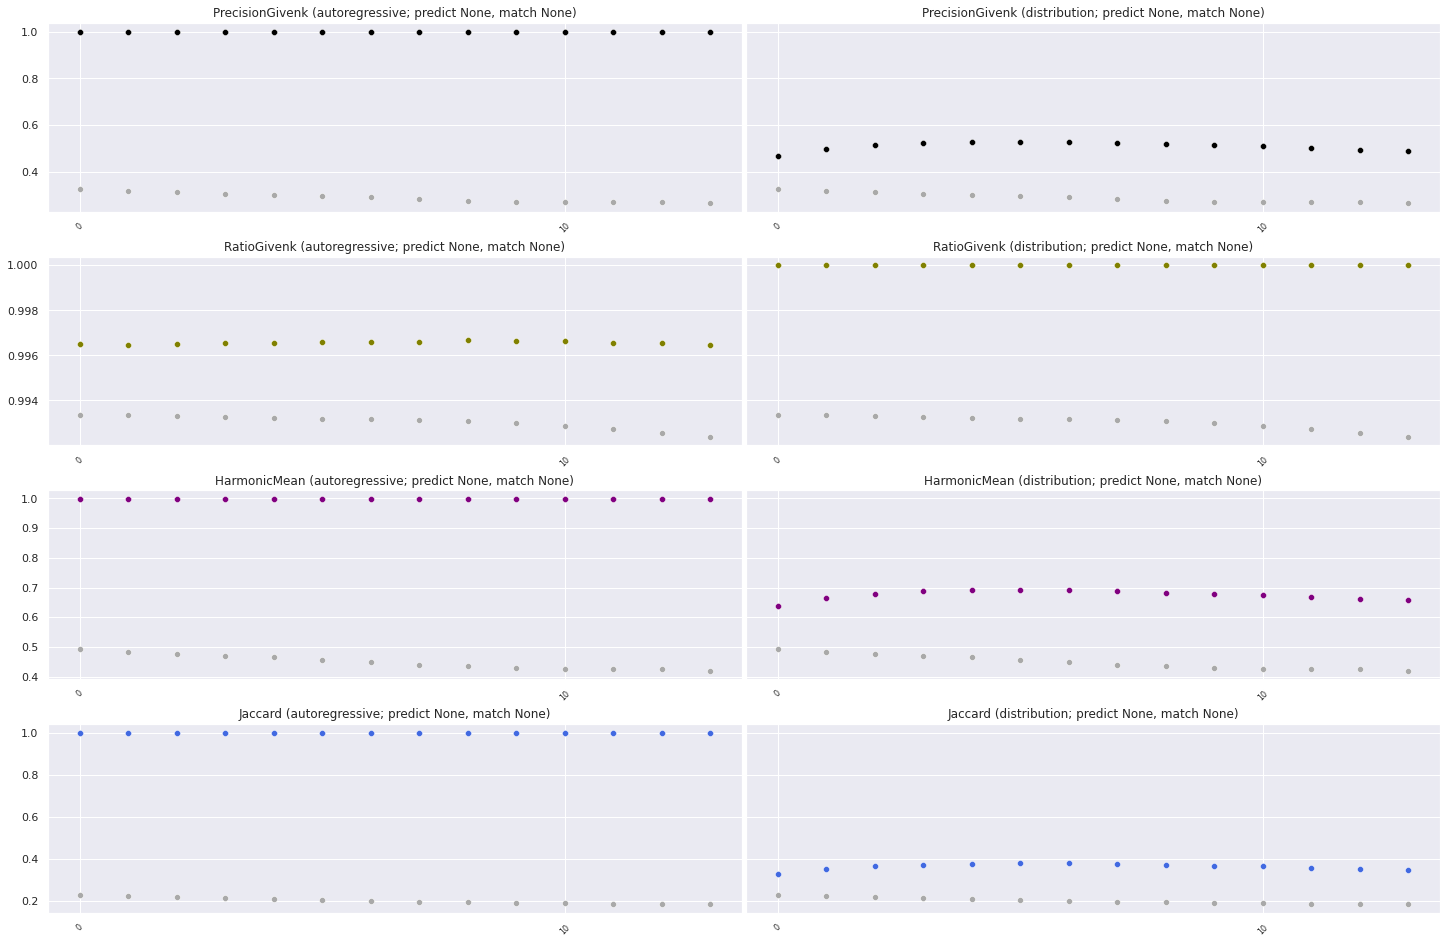

In [109]:
compute_plot_stats(k_all_y, k_all_pred_dst, k_all_y, k_all_used_X, k_all_pred_dummy=k_all_pred_dummy_pk, names=["autoregressive", "distribution"], to_predict=None, to_match=None)

### Tests 
    - calculate set stats compared to full spectrum (not a good idea)
    - calculate set stats to n corresponding (k, k+n) reference peaks
    - calculate set stats to chosen l reference peaks (k, k+l)

#### Test 1 - Start by given top k, predict the rest of the sequence

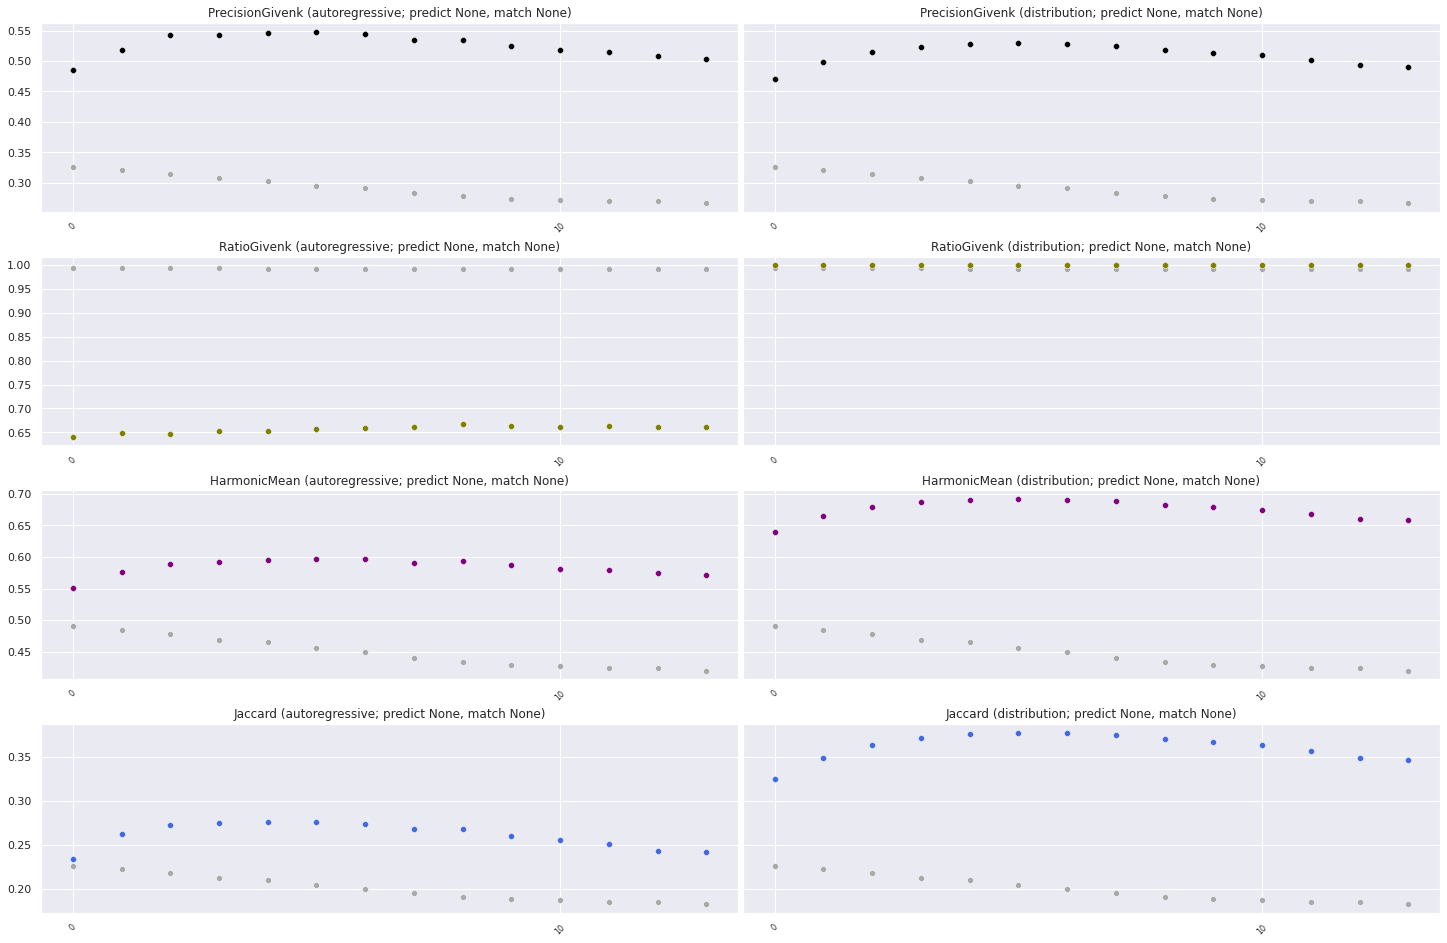

In [110]:
compute_plot_stats(k_all_pred, k_all_pred_dst, k_all_y, k_all_used_X, k_all_pred_dummy=k_all_pred_dummy_pk, names=["autoregressive", "distribution"], to_predict=None, to_match=None)

#### Test 2- Start by given top k, predict the next 5, match with 5 

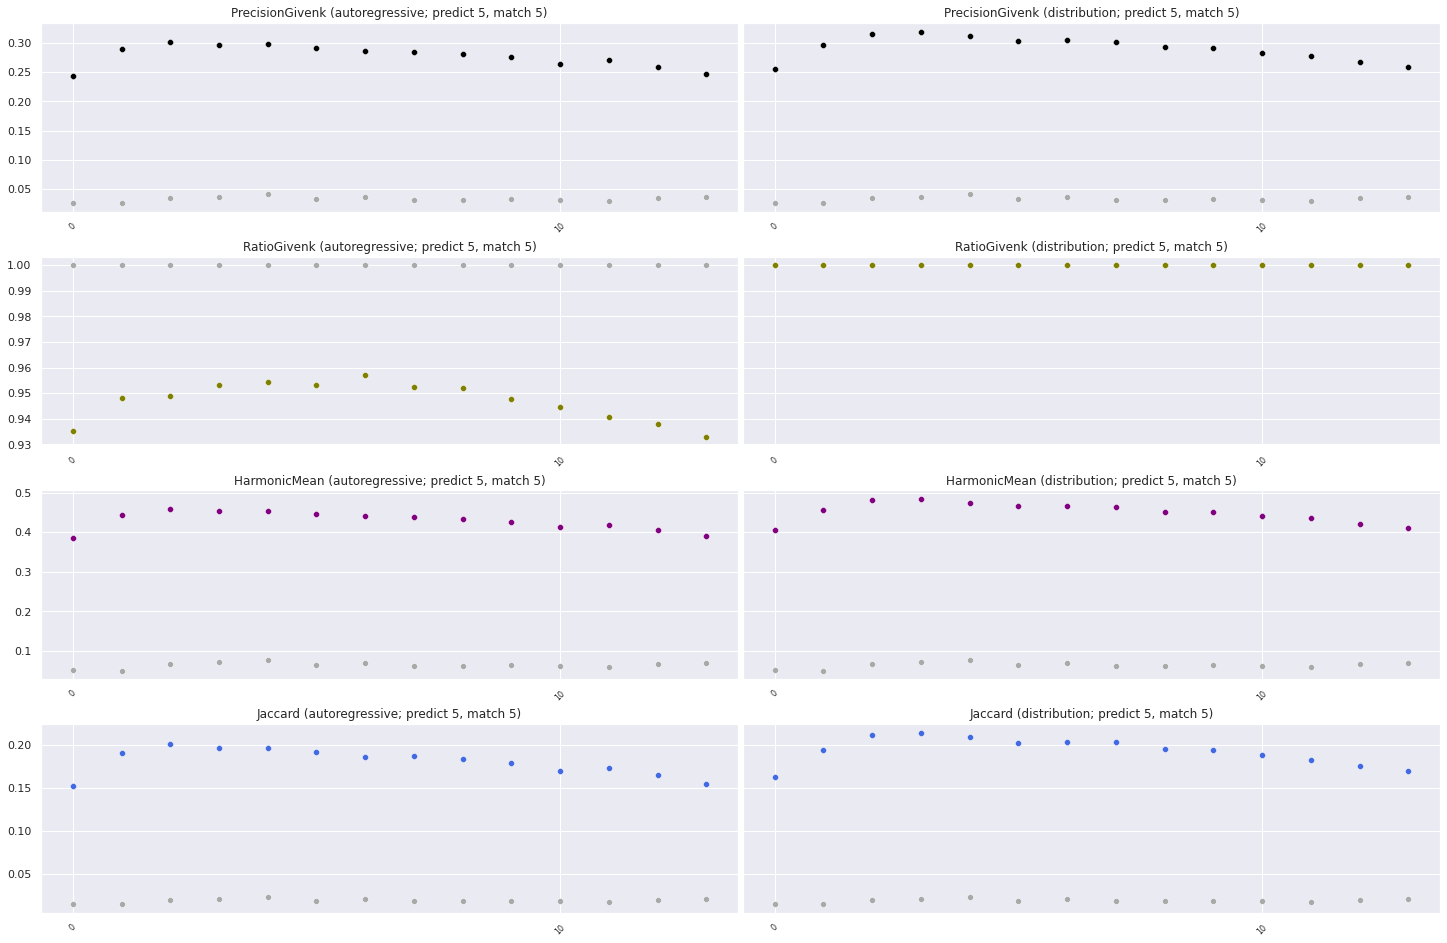

In [111]:
compute_plot_stats(k_all_pred, k_all_pred_dst, k_all_y, k_all_used_X, k_all_pred_dummy=k_all_pred_dummy_pk, names=["autoregressive", "distribution"], to_predict=5, to_match=5)

#### Test 3 - Start by given top k, predict the next n=10, match with 10

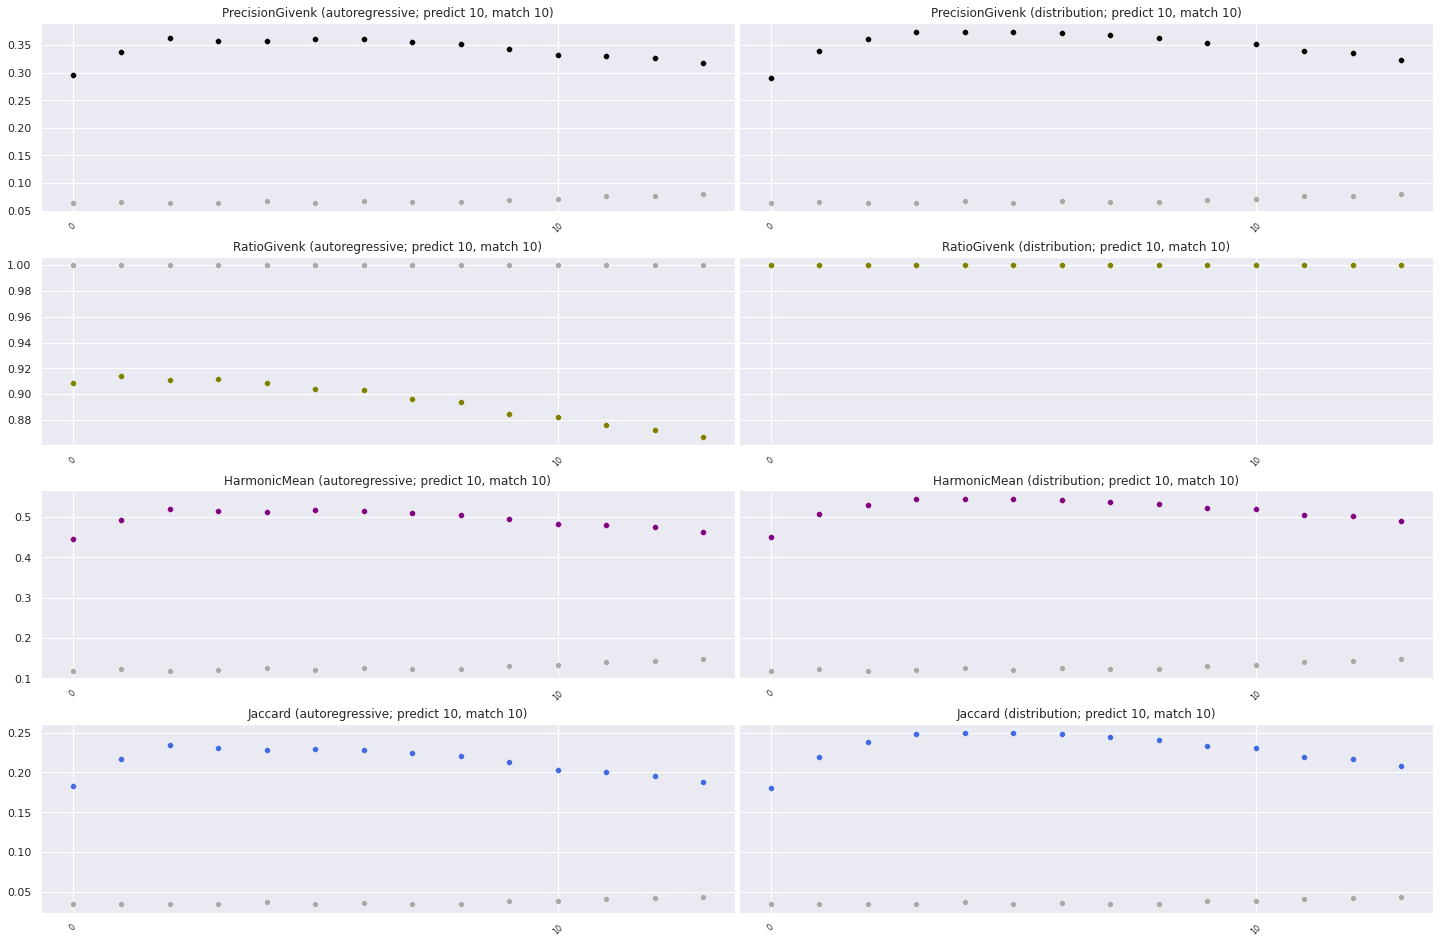

In [112]:
compute_plot_stats(k_all_pred, k_all_pred_dst, k_all_y, k_all_used_X, k_all_pred_dummy=k_all_pred_dummy_pk, names=["autoregressive", "distribution"], to_predict=10, to_match=10)

#### Test 4 - Given top k, predict next n=10 peaks, match with the reference rest

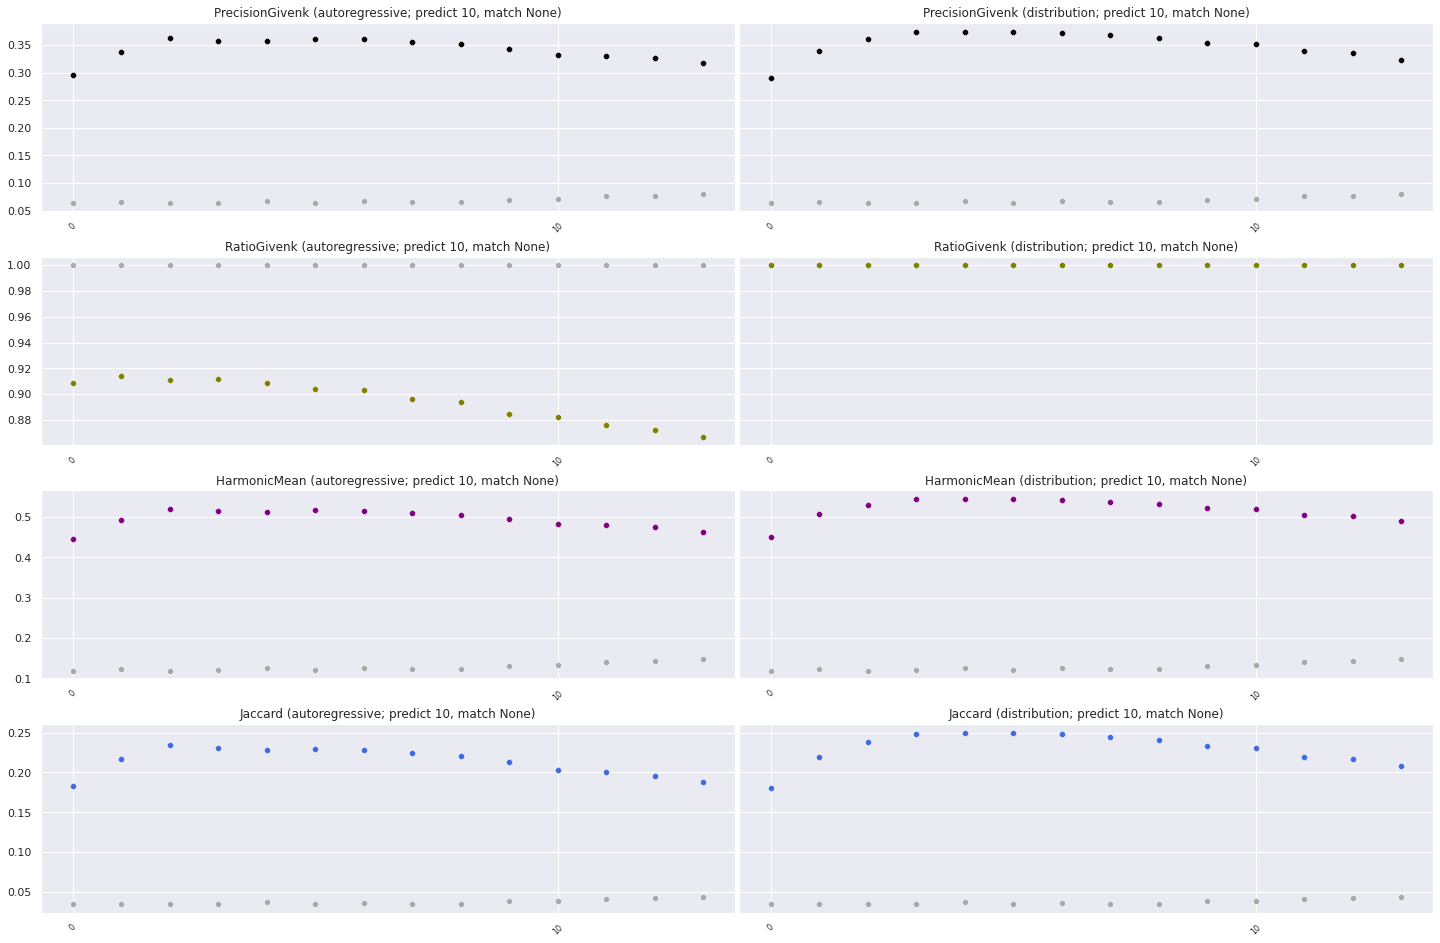

In [113]:
compute_plot_stats(k_all_pred, k_all_pred_dst, k_all_y, k_all_used_X, k_all_pred_dummy=k_all_pred_dummy_pk, names=["autoregressive", "distribution"], to_predict=10, to_match=None)

#### Test 5 - Given top k, predict next n=5 peaks (autoregressive, dst), match with the 10 reference 

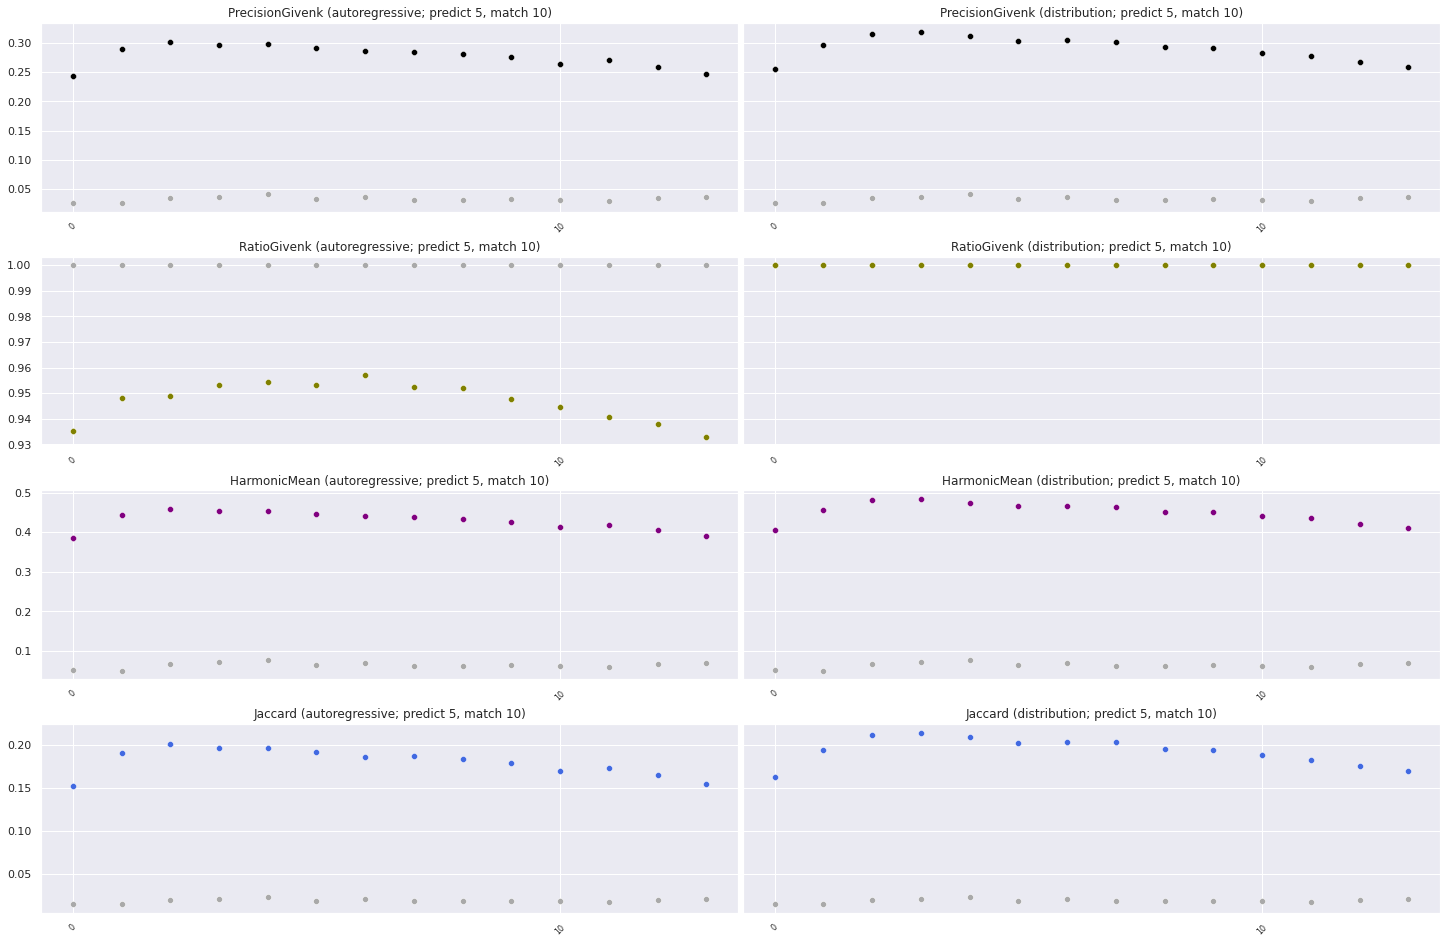

In [114]:
compute_plot_stats(k_all_pred, k_all_pred_dst, k_all_y, k_all_used_X, k_all_pred_dummy=k_all_pred_dummy_pk, names=["autoregressive", "distribution"], to_predict=5, to_match=10)

#### Test 6 - Given top k, predict next n=3 peaks (autoregressive, dst), match with the 6 reference 

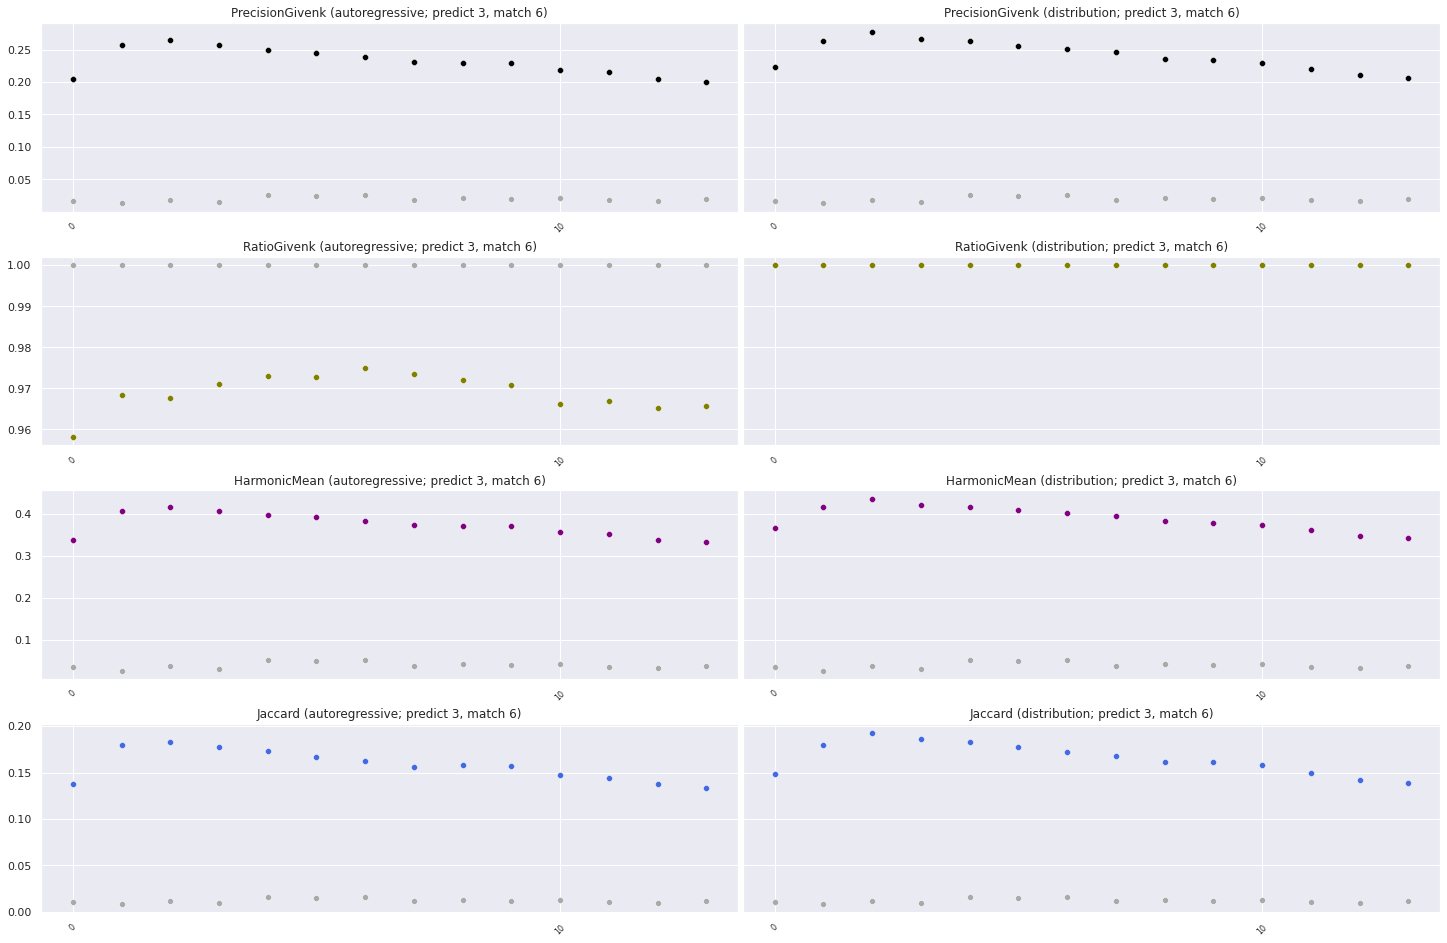

In [115]:
compute_plot_stats(k_all_pred, k_all_pred_dst, k_all_y, k_all_used_X, k_all_pred_dummy=k_all_pred_dummy_pk, names=["autoregressive", "distribution"], to_predict=3, to_match=6)

TODO - plot prediction stats with respect to molecule exact mass

#### TODO Test 10 - Given top k, predict next n peaks, aggregate

## TODO Performance score
- select particular $n$ of n weighting
- for each k get f1/AUC of the selected (n weighting)
- aggregate 

## DEPRECATED
old stuff

In [103]:
class Learner_():
    def __init__(self,train_loader, val_loader, model, optimizer, loss_fn, device, model_name="model"):
        self.train_loader= train_loader
        self.val_loader = val_loader
        self.model = model 
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.model_name=model_name
        self.train_losses = []
        self.val_losses = []
        
        
    def evaluate(self, loader):
        eval_loss = 0
        self.model.eval()
        self.model.to(self.device)
        for b, (X, y) in tqdm.tqdm(enumerate(loader), total=len(loader), position=0, leave=True):
            with torch.no_grad():
                X, y = X.to(self.device), y.to(self.device)
                log_pred, _ = self.model(X)
                loss = self.loss_fn(log_pred, y)
                
                eval_loss += loss.item()
            
        eval_loss /= len(loader)
        
        return eval_loss
    
    def train(self,n_epochs, early_stopping=True, es_limit=3):
        self.model.to(self.device)

        if early_stopping:
            min_val_loss = np.inf
            no_improve = 0
        
        
        for e in range(n_epochs):
            # train
            train_loss = 0
            self.model.train()
            for b, (X, y) in tqdm.tqdm(enumerate(self.train_loader), total=len(self.train_loader), position=0, leave=True):

                X, y = X.to(self.device), y.to(self.device)
                # zero the parameter gradients
                self.optimizer.zero_grad()
                log_pred, _ = self.model(X)
 
                loss = self.loss_fn(log_pred, y)
                loss.backward()
                self.optimizer.step()

            # evaluate (train, validation)
            train_loss = self.evaluate(self.train_loader)
            val_loss = self.evaluate(self.val_loader)

            # early stopping
            if early_stopping:
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    torch.save(self.model, "models/" + self.model_name)
                    no_improve = 0
                else:
                    no_improve += 1
            if no_improve > es_limit:
                print("Early stopped")
                self.model = torch.load("models/" + self.model_name)
                break
            
            print(f"After {e+1} epochs: ")
            print(f"Train loss: {train_loss:.3}")
            print(f"Val loss: {val_loss:.3}\n")
                
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
        
        return self.train_losses, self.val_losses

    


In [104]:
# def set_stats_given_k(k_all_pred, k_all_y, k_all_used_X, to_predict=None, to_match=None):
#     #max_len = max(map( len, all_y))
#     all_precisions_given_k = []#np.zeros((len(k_all_pred), len(k_all_pred[0])))
#     all_recalls_given_k = []#np.zeros((len(k_all_pred), len(k_all_pred[0])))
#     all_jaccards_given_k = []
    
#     for k, (all_pred, all_y, all_used_X) in enumerate(zip(k_all_pred, k_all_y, k_all_used_X)):
#         filtered_all_pred = []
#         rest_all_y = []
#         for p, y, used_X in zip(all_pred, all_y, all_used_X):
#             top_k, rest = used_X, y[k:]
#             p = p[k:]
#             if to_predict is not None:
#                 p = p[:to_predict]
#             if to_match is not None:
#                 rest = rest[:to_match]

                
#             top_k_set = set(top_k.tolist())
#             filtered_p = set(p.tolist()).difference(top_k_set)
#             filtered_all_pred.append(torch.tensor(list(filtered_p)))
#             rest_all_y.append(rest)
#             #print(filtered_all_pred[-1])
#             #print(rest_all_y[-1])
#         #print(k)
#         pr, rec, jac = get_set_stats(filtered_all_pred, rest_all_y)
#         all_precisions_given_k.append(pr)
#         all_recalls_given_k.append(rec)
#         all_jaccards_given_k.append(jac)
#     return all_precisions_given_k, all_recalls_given_k, all_jaccards_given_k

In [105]:

# def get_set_stats(all_pred, all_y):
#     all_precisions = np.zeros(len(all_pred))
#     all_recalls = np.zeros(len(all_pred))
#     all_jaccards = np.zeros(len(all_pred))
#     for i, (y_pred, y) in enumerate(zip(all_pred, all_y)):
#         y_pred = set(y_pred.tolist())
#         y = set(y.tolist())
#         TP = len(y.intersection(y_pred))
#         FP = len(y_pred) - TP
#         FN = len(y) - TP
#         #if len(y) != len(y_pred):
#         #    print(y - y_pred)
#         set_precision = TP/ (TP + FP) if TP+FP != 0 else np.NaN
#         set_recall = TP/ (TP + FN) if TP+FN != 0 else np.NaN
#         if len(y.union(y_pred)) == 0:
#             print(i, "ou")
#             jaccard = np.NaN
#         else: 
#             jaccard = TP/ len(y.union(y_pred))
        
#         all_precisions[i] = set_precision
#         all_recalls[i] = set_recall
#         all_jaccards[i] = jaccard
#     return all_precisions, all_recalls, all_jaccards
#all_precisions, all_recalls = get_set_stats(all_pred_tf, all_y_tf)

In [106]:
def plot_stats3(data1D1,data1D2, data1D3, max_len=None, titles=None, color=["blue", "blue", "blue"]):
    #plt.figure(figsize=(20,10))
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,10))
    
    if max_len is None:
        max_len = len(data1D1)
    ax1 = sns.scatterplot(y=data1D1[:max_len], x=np.arange(max_len)+1, color=color[0], ax=ax1)#, hue=np.ones(max_len)*style, palette="tab10") #Paired_r
    ax2 = sns.scatterplot(y=data1D2[:max_len], x=np.arange(max_len)+1, color=color[1], ax=ax2)#, hue=np.ones(max_len)*style, palette="tab10") #Paired_r
    ax3 = sns.scatterplot(y=data1D3[:max_len], x=np.arange(max_len)+1, color=color[2], ax=ax3)#, hue=np.ones(max_len)*style, palette="tab10") #Paired_r
    
    plt.sca(ax1)    
    plt.xticks(ticks=np.arange(0,max_len,10),fontsize=8, rotation=45)
    
    plt.sca(ax2)    
    plt.xticks(ticks=np.arange(0,max_len,10),fontsize=8, rotation=45)
    
    plt.sca(ax3)    
    plt.xticks(ticks=np.arange(0,max_len,10),fontsize=8, rotation=45)
    
    if titles:
        plt.sca(ax1)
        plt.title(titles[0])
        plt.sca(ax2)
        plt.title(titles[1])
        plt.sca(ax3)
        plt.title(titles[2])
        
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
    
    plt.show()

        
def plot_stats6(datas_3D, base_data=None, max_len=None, titles=None, color=["blue", "blue", "blue"]):
    fig, axes = plt.subplots(3, 2, figsize=(20,10), sharey="row")
    
    #(ax1, ax4, ax3), (ax4, ax5, a6)  = axes 
    for i in range(len(axes)):
        for j in range(len(axes[i])):
            if max_len is None:
                max_len = len(datas_3D[j][i])

            axes[i][j] = sns.scatterplot(y=datas_3D[j][i][:max_len], x=np.arange(max_len)+1, color=color[i], ax=axes[i][j])
            plt.sca(axes[i][j])    
            plt.xticks(ticks=np.arange(0,max_len,10),fontsize=8, rotation=45)

            if titles:
                plt.title(titles[j][i])
 
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
    
    plt.show()
    